In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
from matplotlib import rc
rc('font',family='serif')
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as wid
#%matplotlib qt5
%matplotlib inline
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 100
#from ipywidgets import interact

file = open("data.bin", "r")
interleaved_data = np.fromfile(file, np.uint8)
file.close()
# the data is sampled at 2.4Mhz
fs = 2.4E6 #Carrier frequency of SDR
dt = 1/(fs) #Timestep between samples 
symbol_r = 100E3 #Symbol rate

#Below is copied from esc_python_tut
I_data_raw = interleaved_data[0:len(interleaved_data):2]
Q_data_raw = interleaved_data[1:len(interleaved_data):2]

I_samples = (I_data_raw-127.5)/127.5
Q_samples = (Q_data_raw-127.5)/127.5

complex_data = I_samples + 1j*Q_samples

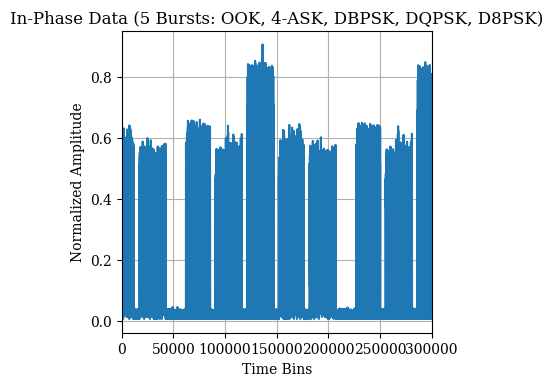

In [3]:
#Below is copied from esc_python_tut
#Plots the magnitude of the complex data against time bins in order to determine the splicing points
plt.figure(1)
plt.plot(np.abs(complex_data))
plt.xlabel("Time Bins")
plt.ylabel("Normalized Amplitude")
plt.xlim(0,len(I_samples))
#plt.xaxis.set_major_formatter(formatter0)
plt.title("In-Phase Data (5 Bursts: OOK, 4-ASK, DBPSK, DQPSK, D8PSK)")
plt.grid()
plt.show()

In [4]:
#Splice variables
OOK_start = 226851
OOK_end = 250000

ASK_start = 90764
ASK_end = 116276

DBPSK_start = 121590
DBPSK_end = 146800

DQPSK_start = 152095
DQPSK_end = 176340

D8PSK_start = 181624
D8PSK_end = 207160

## OOK

### Splicing of the data

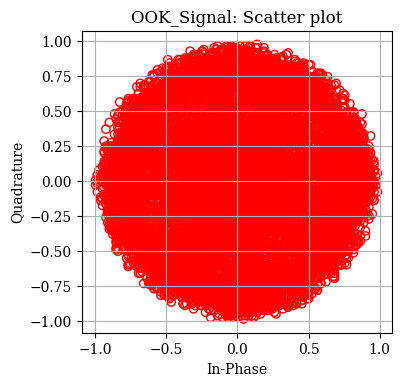

In [5]:
#Splicing of the data
OOK_I = I_samples[OOK_start:OOK_end]
OOK_Q = Q_samples[OOK_start:OOK_end]
OOK_mag = np.abs(complex_data)[OOK_start:OOK_end]

#Normalizing the data
OOK_I = OOK_I / OOK_mag.max()
OOK_Q = OOK_Q / OOK_mag.max()

OOK_signal = OOK_I + 1j*OOK_Q

#Scatter Plot of the OOK data.
plt.figure(1)
plt.scatter(np.real(OOK_signal), np.imag(OOK_signal),facecolors='none', edgecolors='r') 
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("OOK_Signal: Scatter plot")
plt.grid()
plt.show()

### Creating frequency and time arrays

In [43]:
#create a freqency array
freq = np.fft.fftfreq(len(OOK_signal),dt)

#create a time array
bins=np.arange(0,len(OOK_signal),1)
t=bins*dt

### Plotting |OOK_signal|

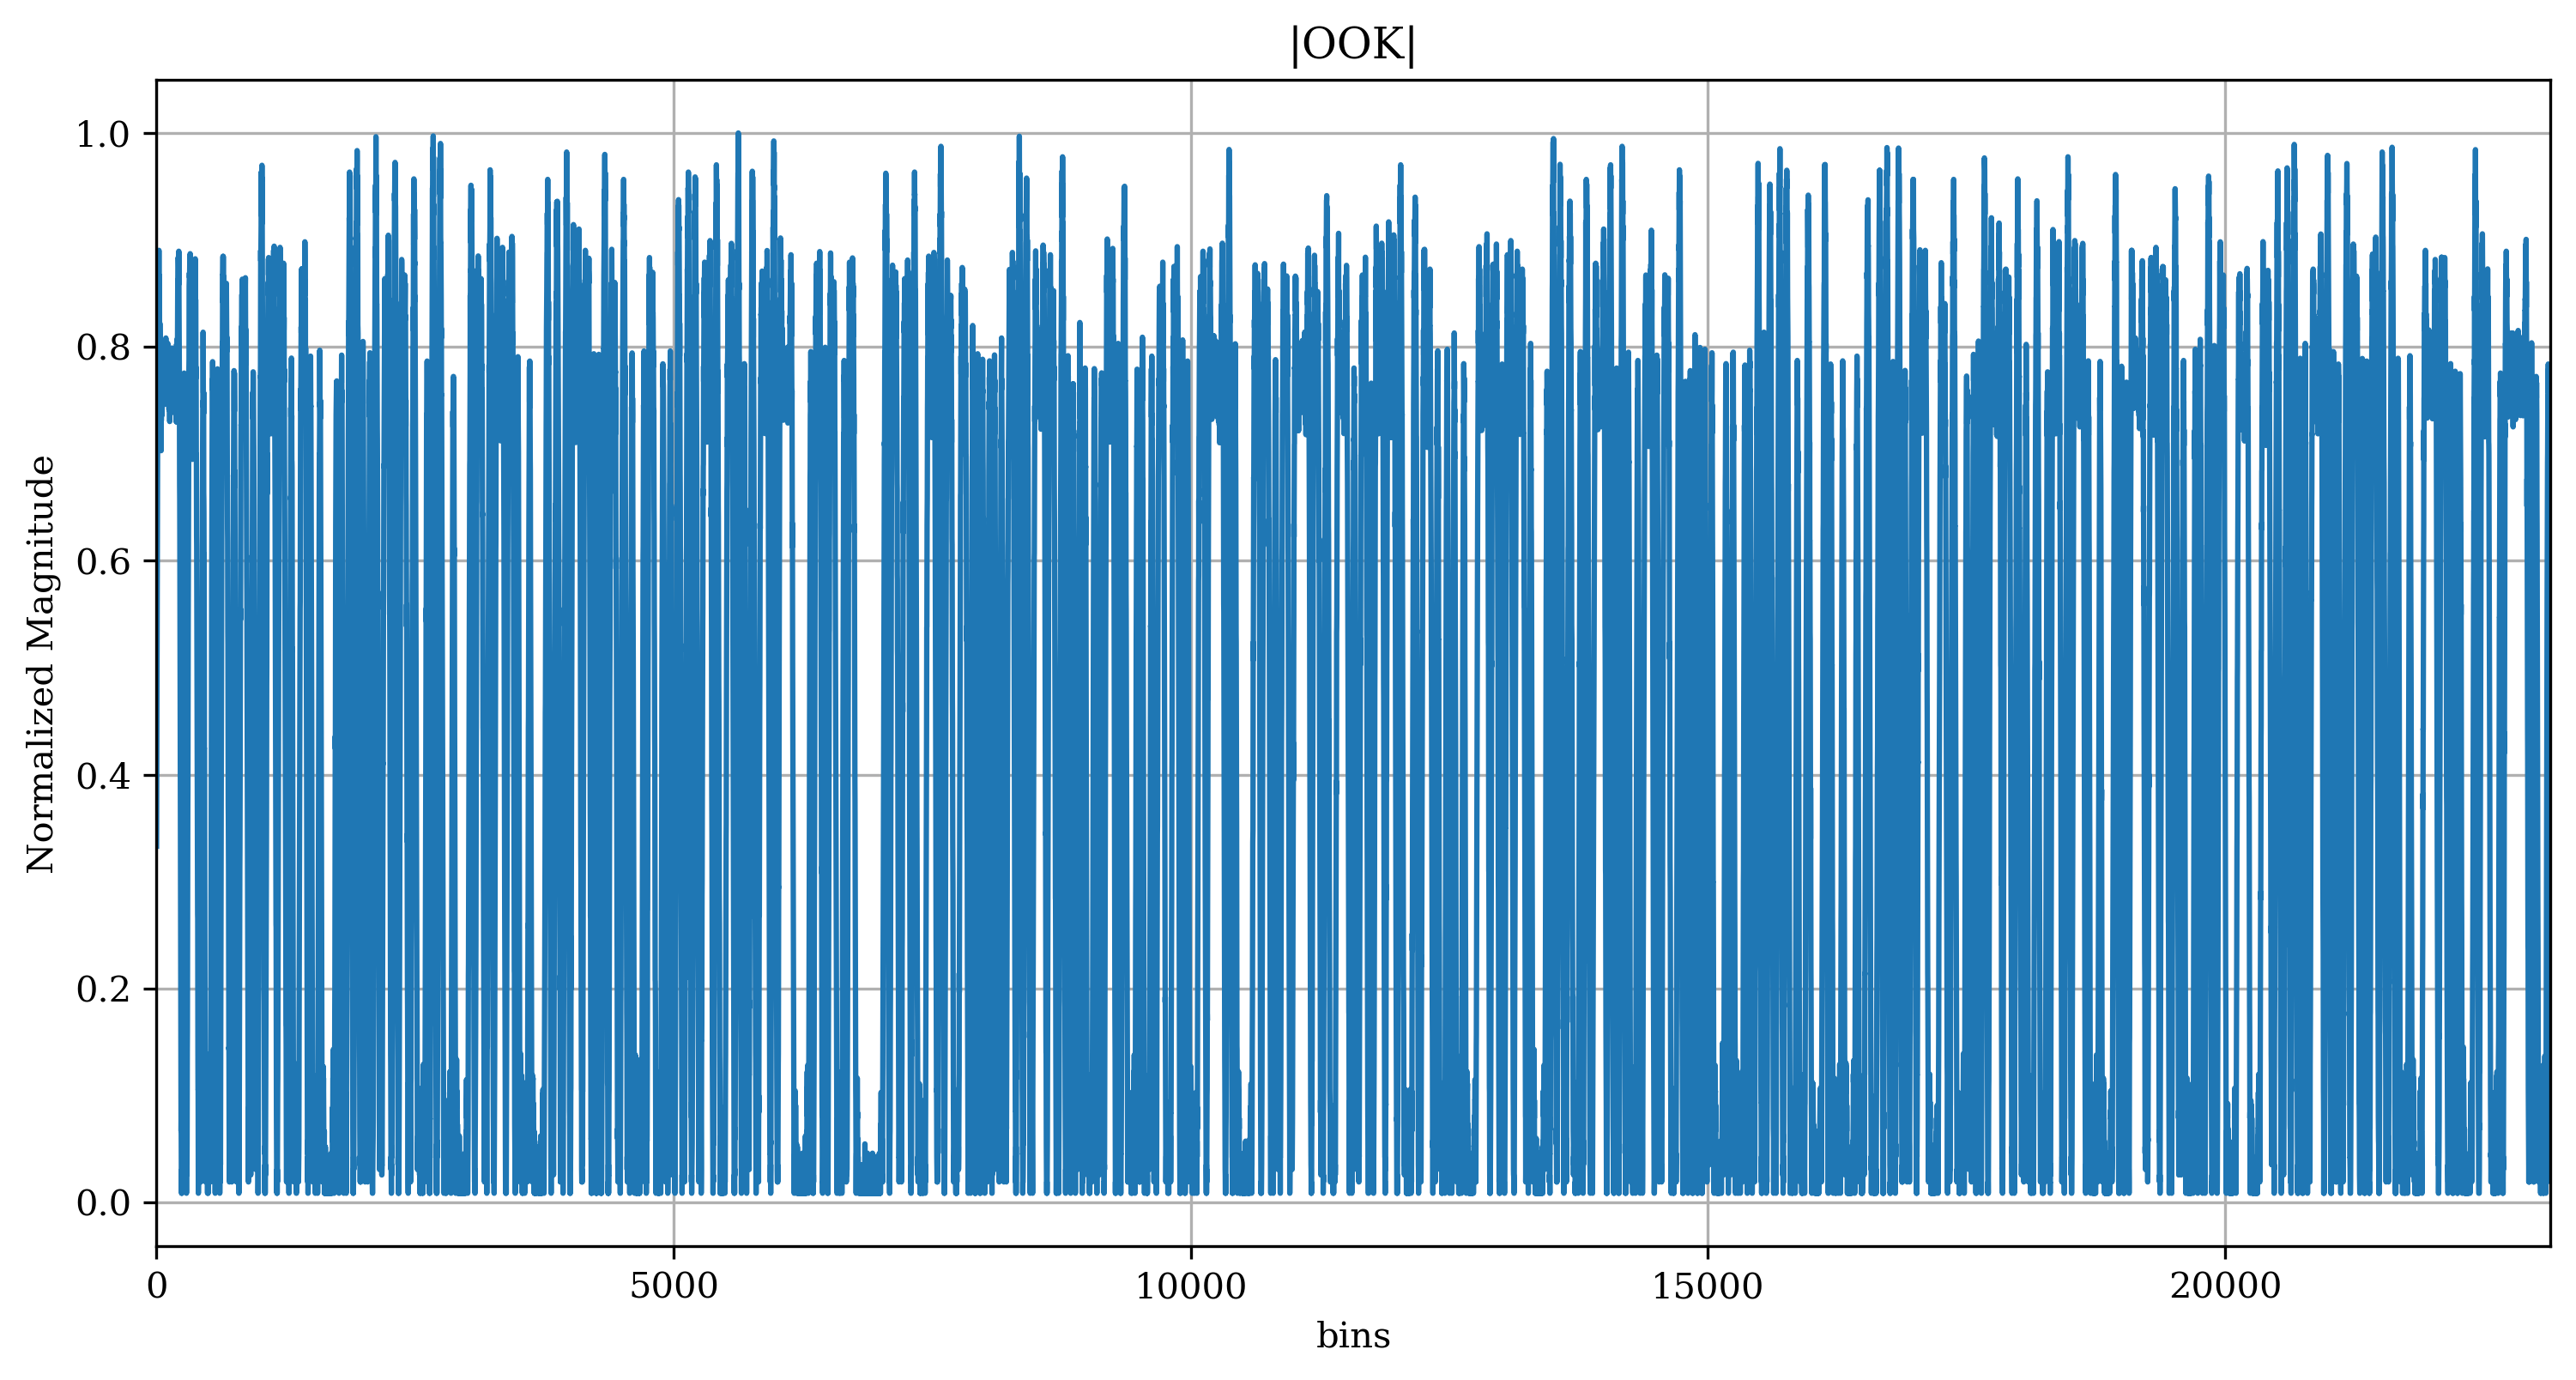

In [44]:
plt.figure(2)
plt.plot(bins,np.abs(OOK_signal))
plt.xlabel("bins") 
plt.ylabel("Normalized Magnitude")
plt.title("|OOK|")
plt.xlim(0,bins.max())
plt.grid()
plt.show()

### Plotting the FFT of OOK_signal and doing corse correction of the frequency offset
Since it is given that the first 10 symbols of the signal are used for syncroization and contain no information it is possible to do a corse frequency offset corrrection by obtaining the median between the phase differnece of these samples

$$ \Delta\Phi = \Phi_{2} - \Phi_{1}$$
since we know that the $\Delta\Phi$ is related to $\Delta f$ by the following equation,
$$\Delta f = \frac{median(\Delta\Phi)}{2 \pi \Delta t} $$

Once one has aquired $\Delta f$ in order to correct the freqency offset one needs to multiply by a complex sinusoide in order to correct the offset this is done acording to the equation below

$$ s(t) \cdot e^{j(\omega_{c}+\omega_{o})\cdot t} \cdot e^{-j\omega_{o}} $$

where $\omega_{o}$ is the offset and $\omega_{c}$ is the carrier thus the following result is obtained

$$ s(t) \cdot e^{j(\omega_{c}+\omega_{o} - \omega_{o})\cdot t} $$

$$ s(t) \cdot e^{j(\omega_{c})t} $$

As one can see the offset has been removed

 Corse Frequency Offset: -595502.9301292223 Hz


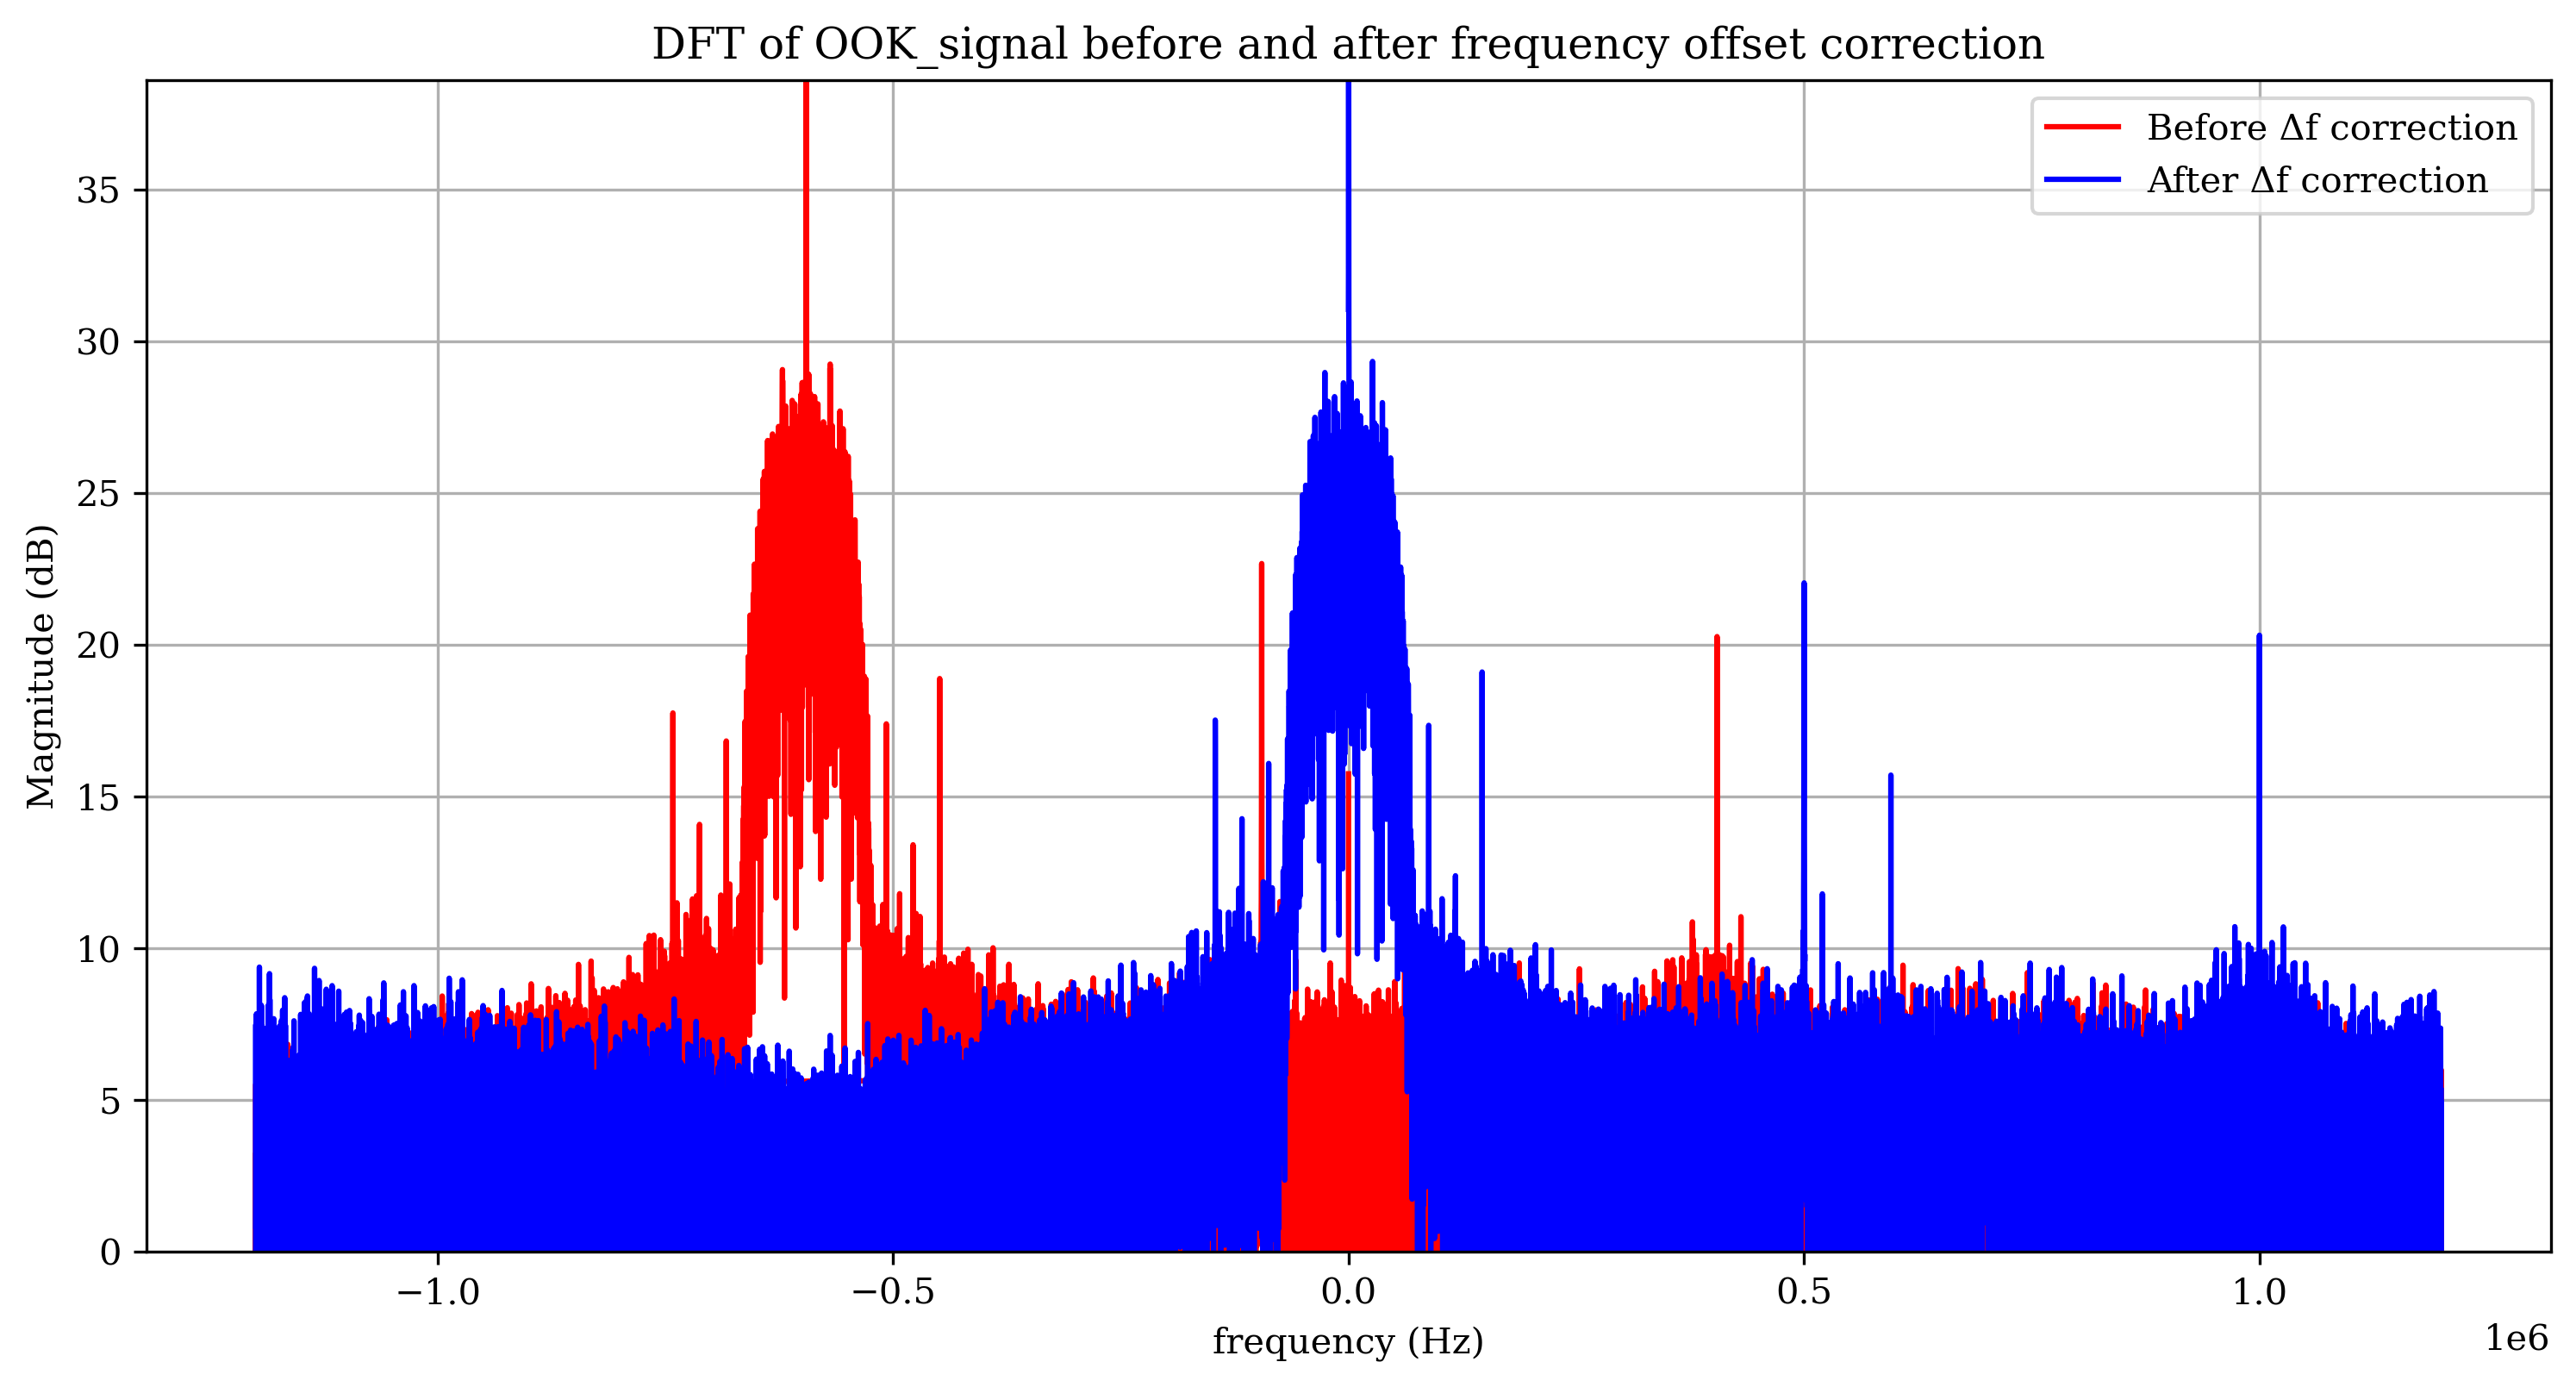

In [45]:
#FFT before corse frequency correction 
OOK_SIGNAL_O = np.fft.fft(OOK_signal)
OOK_MAG_O = 10*np.log10(np.abs(OOK_SIGNAL_O))


Δ_Φ = np.diff(np.unwrap((np.angle(OOK_signal[2:227]))))
Δ_f = np.median(Δ_Φ)  / (np.pi*2*dt)  
print(" Corse Frequency Offset:",Δ_f,'Hz')

#FFT after corse frequency correction
OOK_signal = OOK_signal*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))

OOK_SIGNAL = np.fft.fft(OOK_signal)
OOK_MAG = 10*np.log10(np.abs(OOK_SIGNAL))

#Plotting the results


f, ax = plt.subplots(1,1)


ax.plot(freq,OOK_MAG_O,'r',label='Before Δf correction')
ax.plot(freq,OOK_MAG,'b',label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of OOK_signal before and after frequency offset correction")
plt.legend(loc='upper right')
plt.ylim(0,OOK_MAG_O.max())
plt.grid()
plt.show()

### Downsampling of the data

The recived data now needs to be downsampled this means that the data only contains symbols at certain increments and thus we need to obtain the frequency and phase of the ogrinal sampling clock in order to reproduce the the sampling clock and syncronise with the symbols.
<br>
This is done by taking the DFT|data| by taking the DFT of the absolute one removes the frequency and phase offset.
<br>
Since it is provided that the system has a symbol rate of around 100,000 symbols per second then a large oberservable spike should accour at around that point.
<br>
*[Note] It is not at exactly 100 kHz because there is error in the local oscilator in the SDR, therefore it does not match up exactly

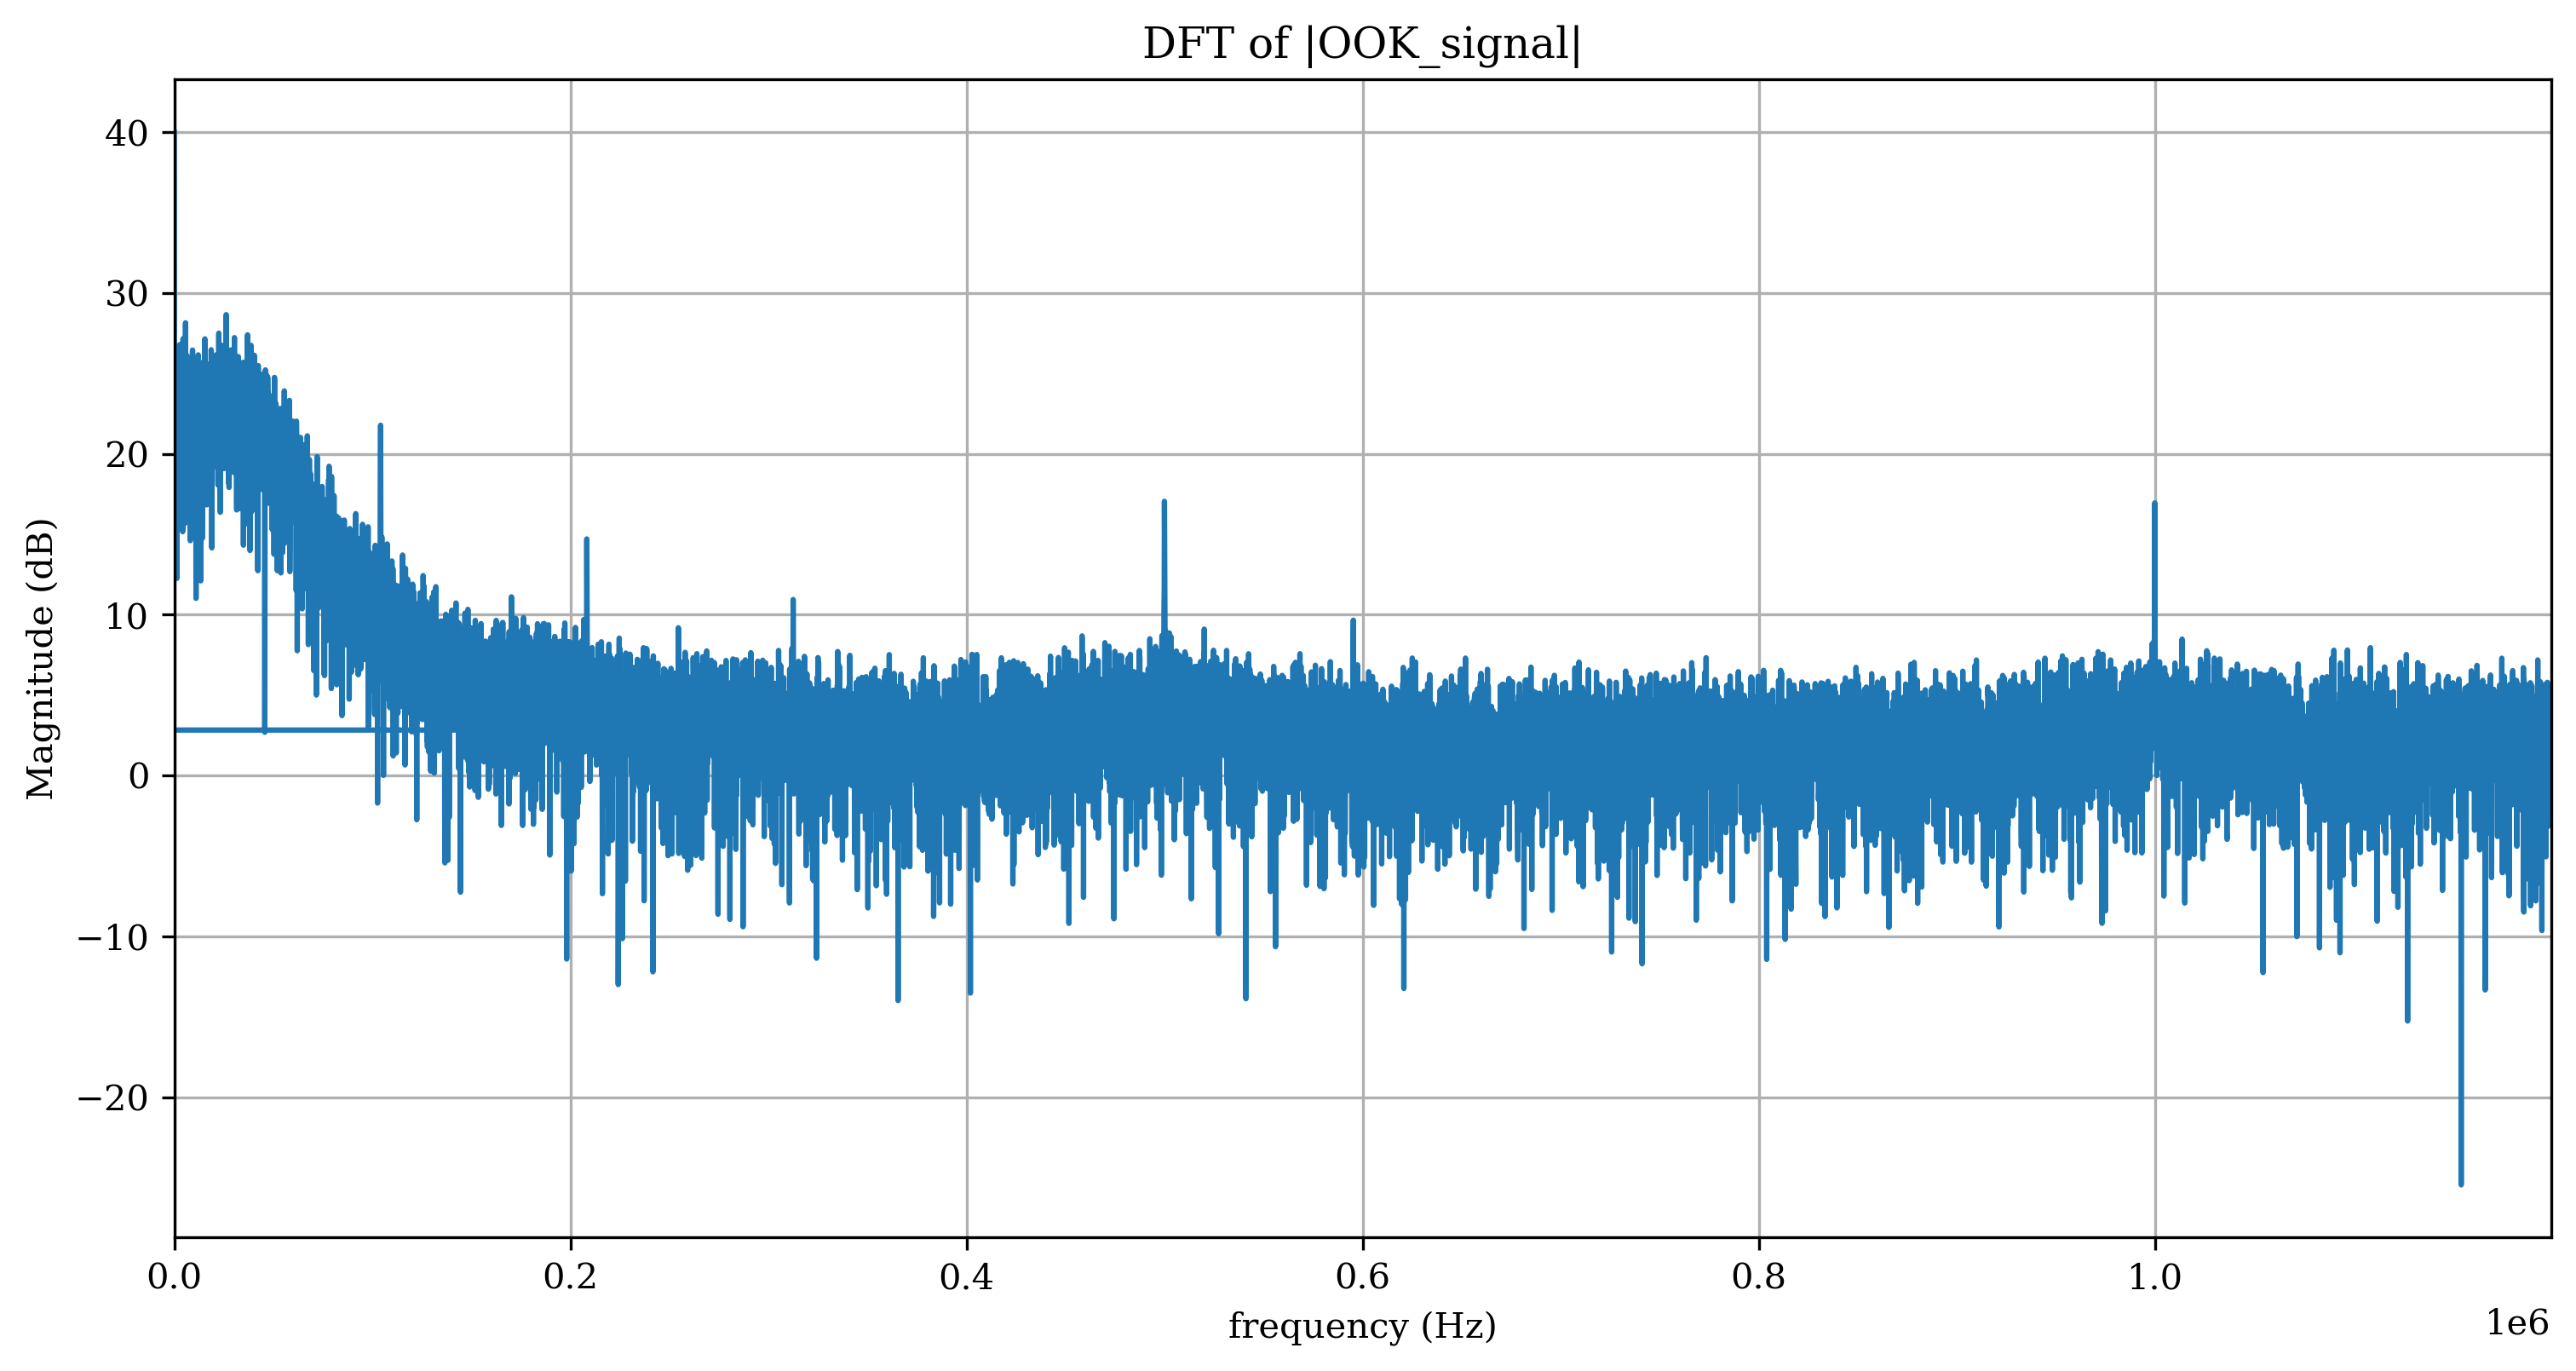

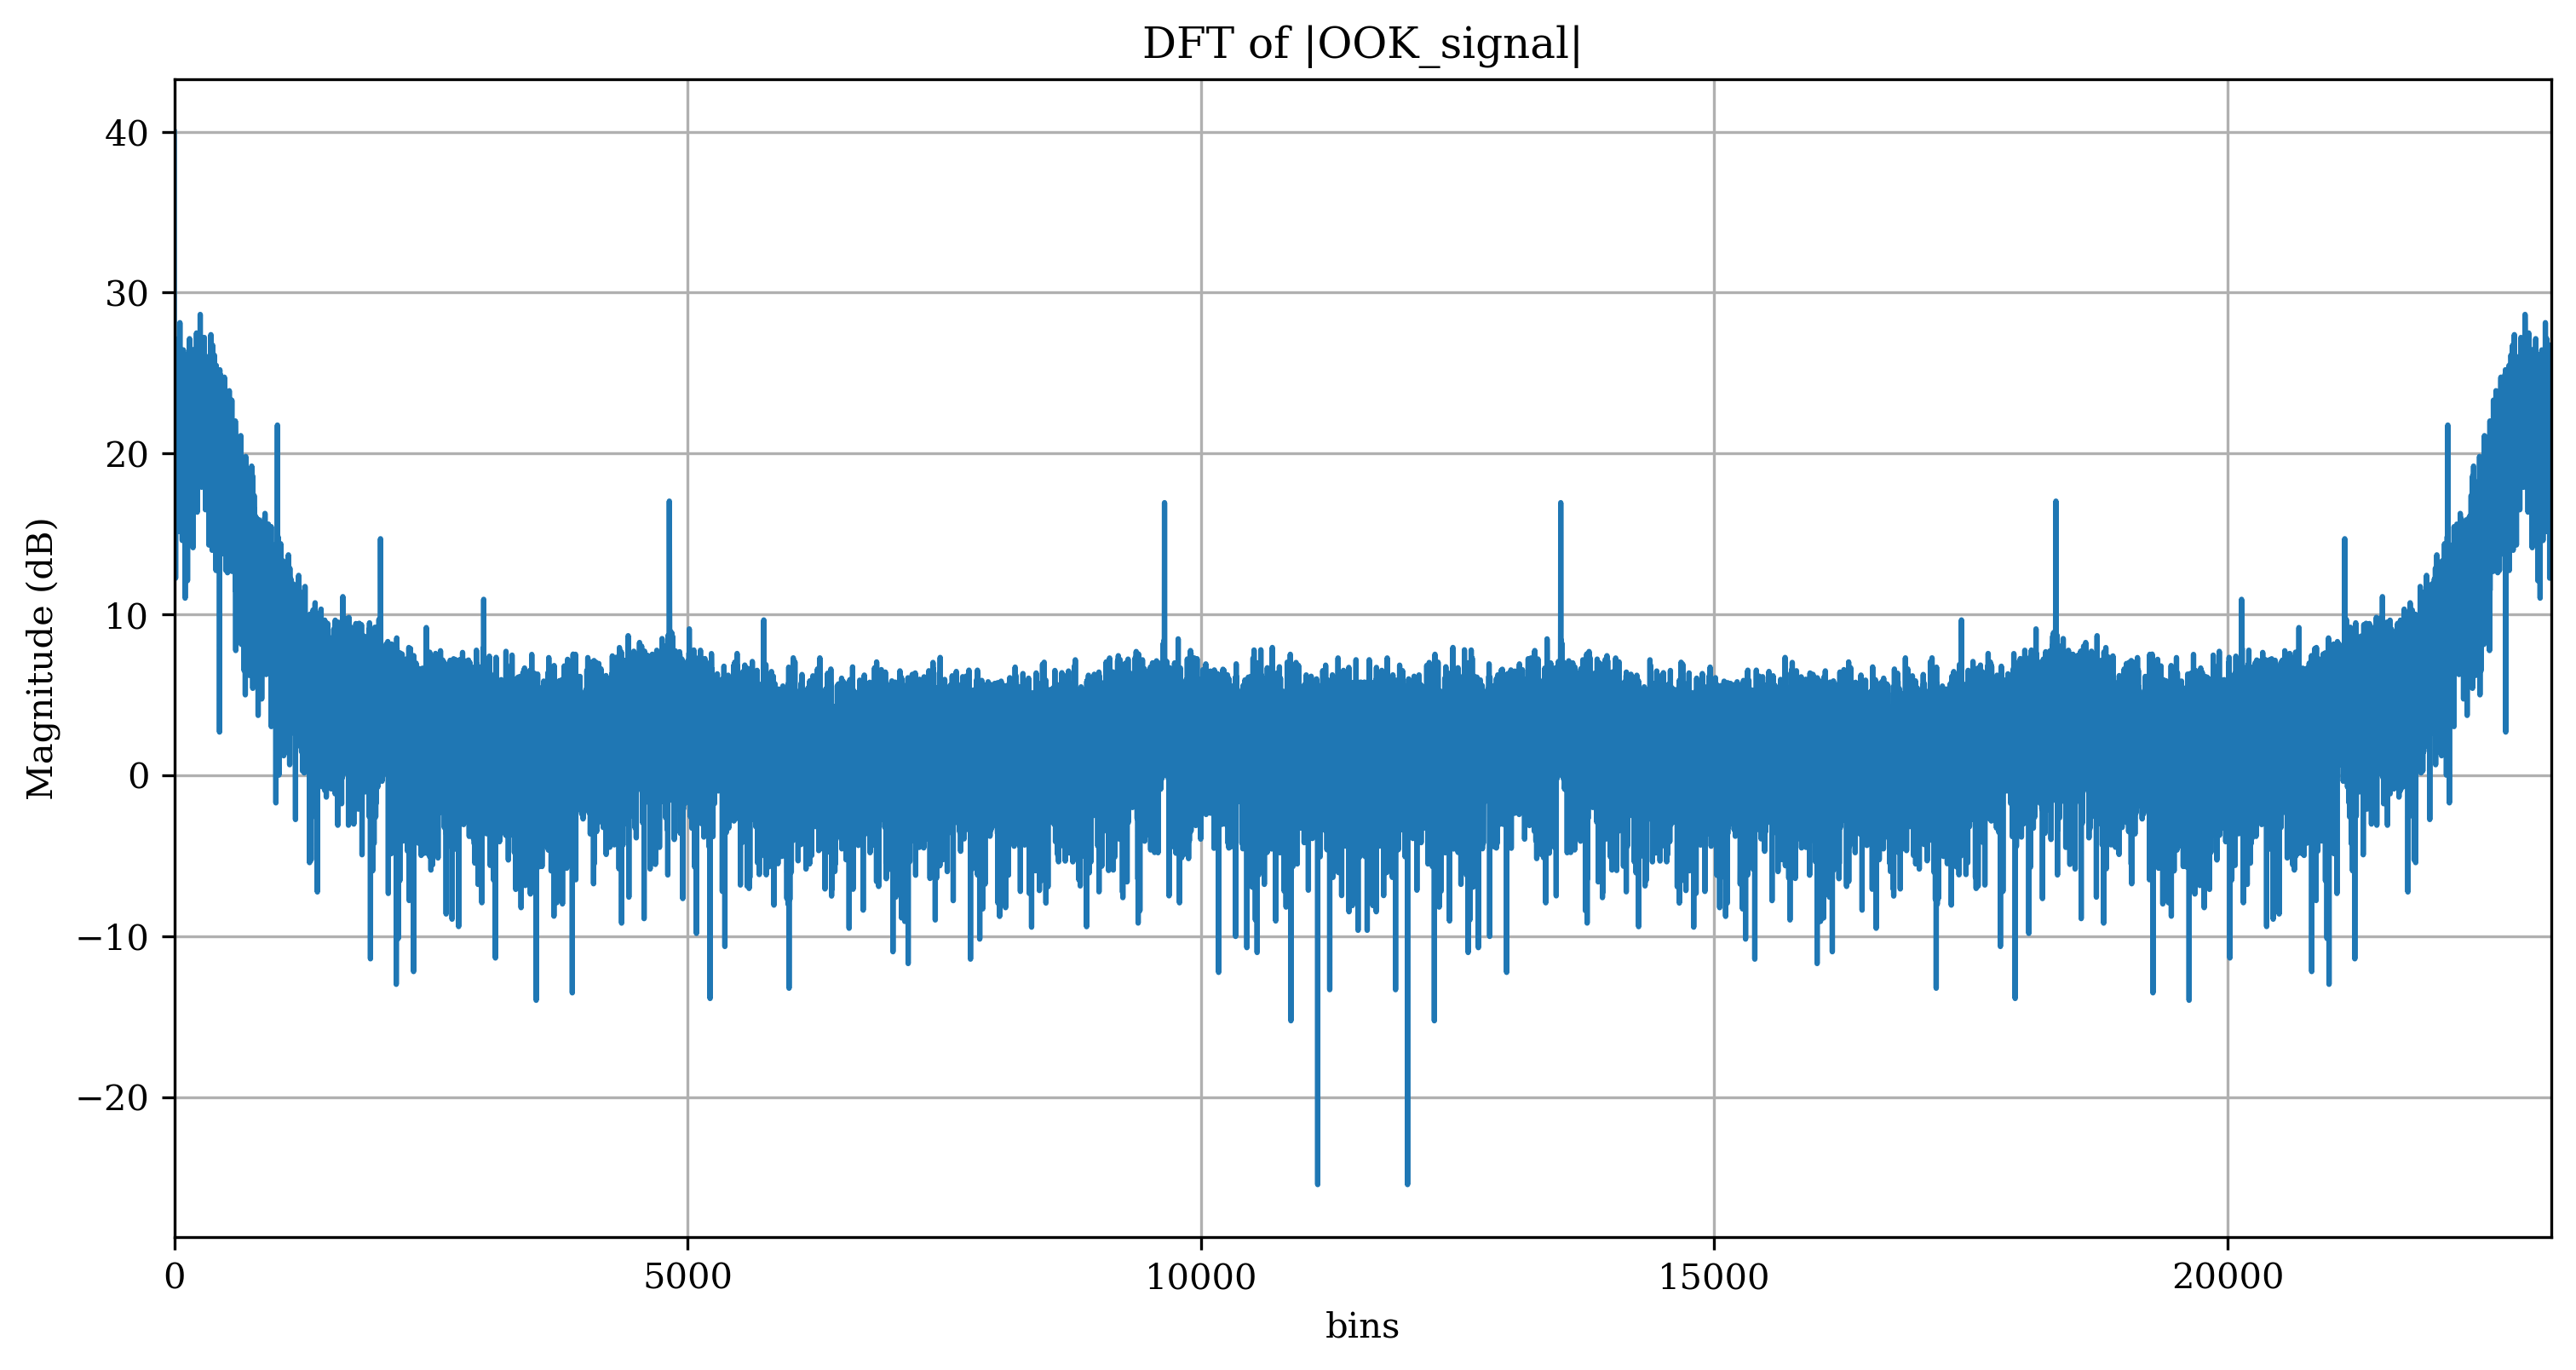

In [46]:
#DFT of |OOK_signal|
OOK_SIGNAL_ABS = np.fft.fft(np.abs(OOK_signal))
OOK_MAG_ABS = 10*np.log10(np.abs(OOK_SIGNAL_ABS))
OOK_SIGNAL_Φ = np.unwrap(np.pi/4 - np.angle(OOK_SIGNAL_ABS))

f1, ax = plt.subplots(1,1)
#ax.xaxis.set_major_formatter(formatter0)
ax.plot(freq,OOK_MAG_ABS)
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of |OOK_signal|")
plt.xlim(-1,freq.max())
plt.grid()
plt.show()

f2, ax = plt.subplots(1,1)
#ax.xaxis.set_major_formatter(formatter0)
ax.plot(bins,OOK_MAG_ABS)
plt.xlabel("bins") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of |OOK_signal|")
plt.xlim(0,bins.max())
plt.grid()
plt.show()

Once the frequency spike(which represents the data) is located one may also optain the $\Phi_{clock}$ by the following equation
$$\Phi_{clock} = tan^{-1}(Q/I)$$ where Q and I are the compents at the freqency spike.

Clock Frequency: 654673.7639171092 Hz
Φ: -4.05583503984194 radians
bin: 1005


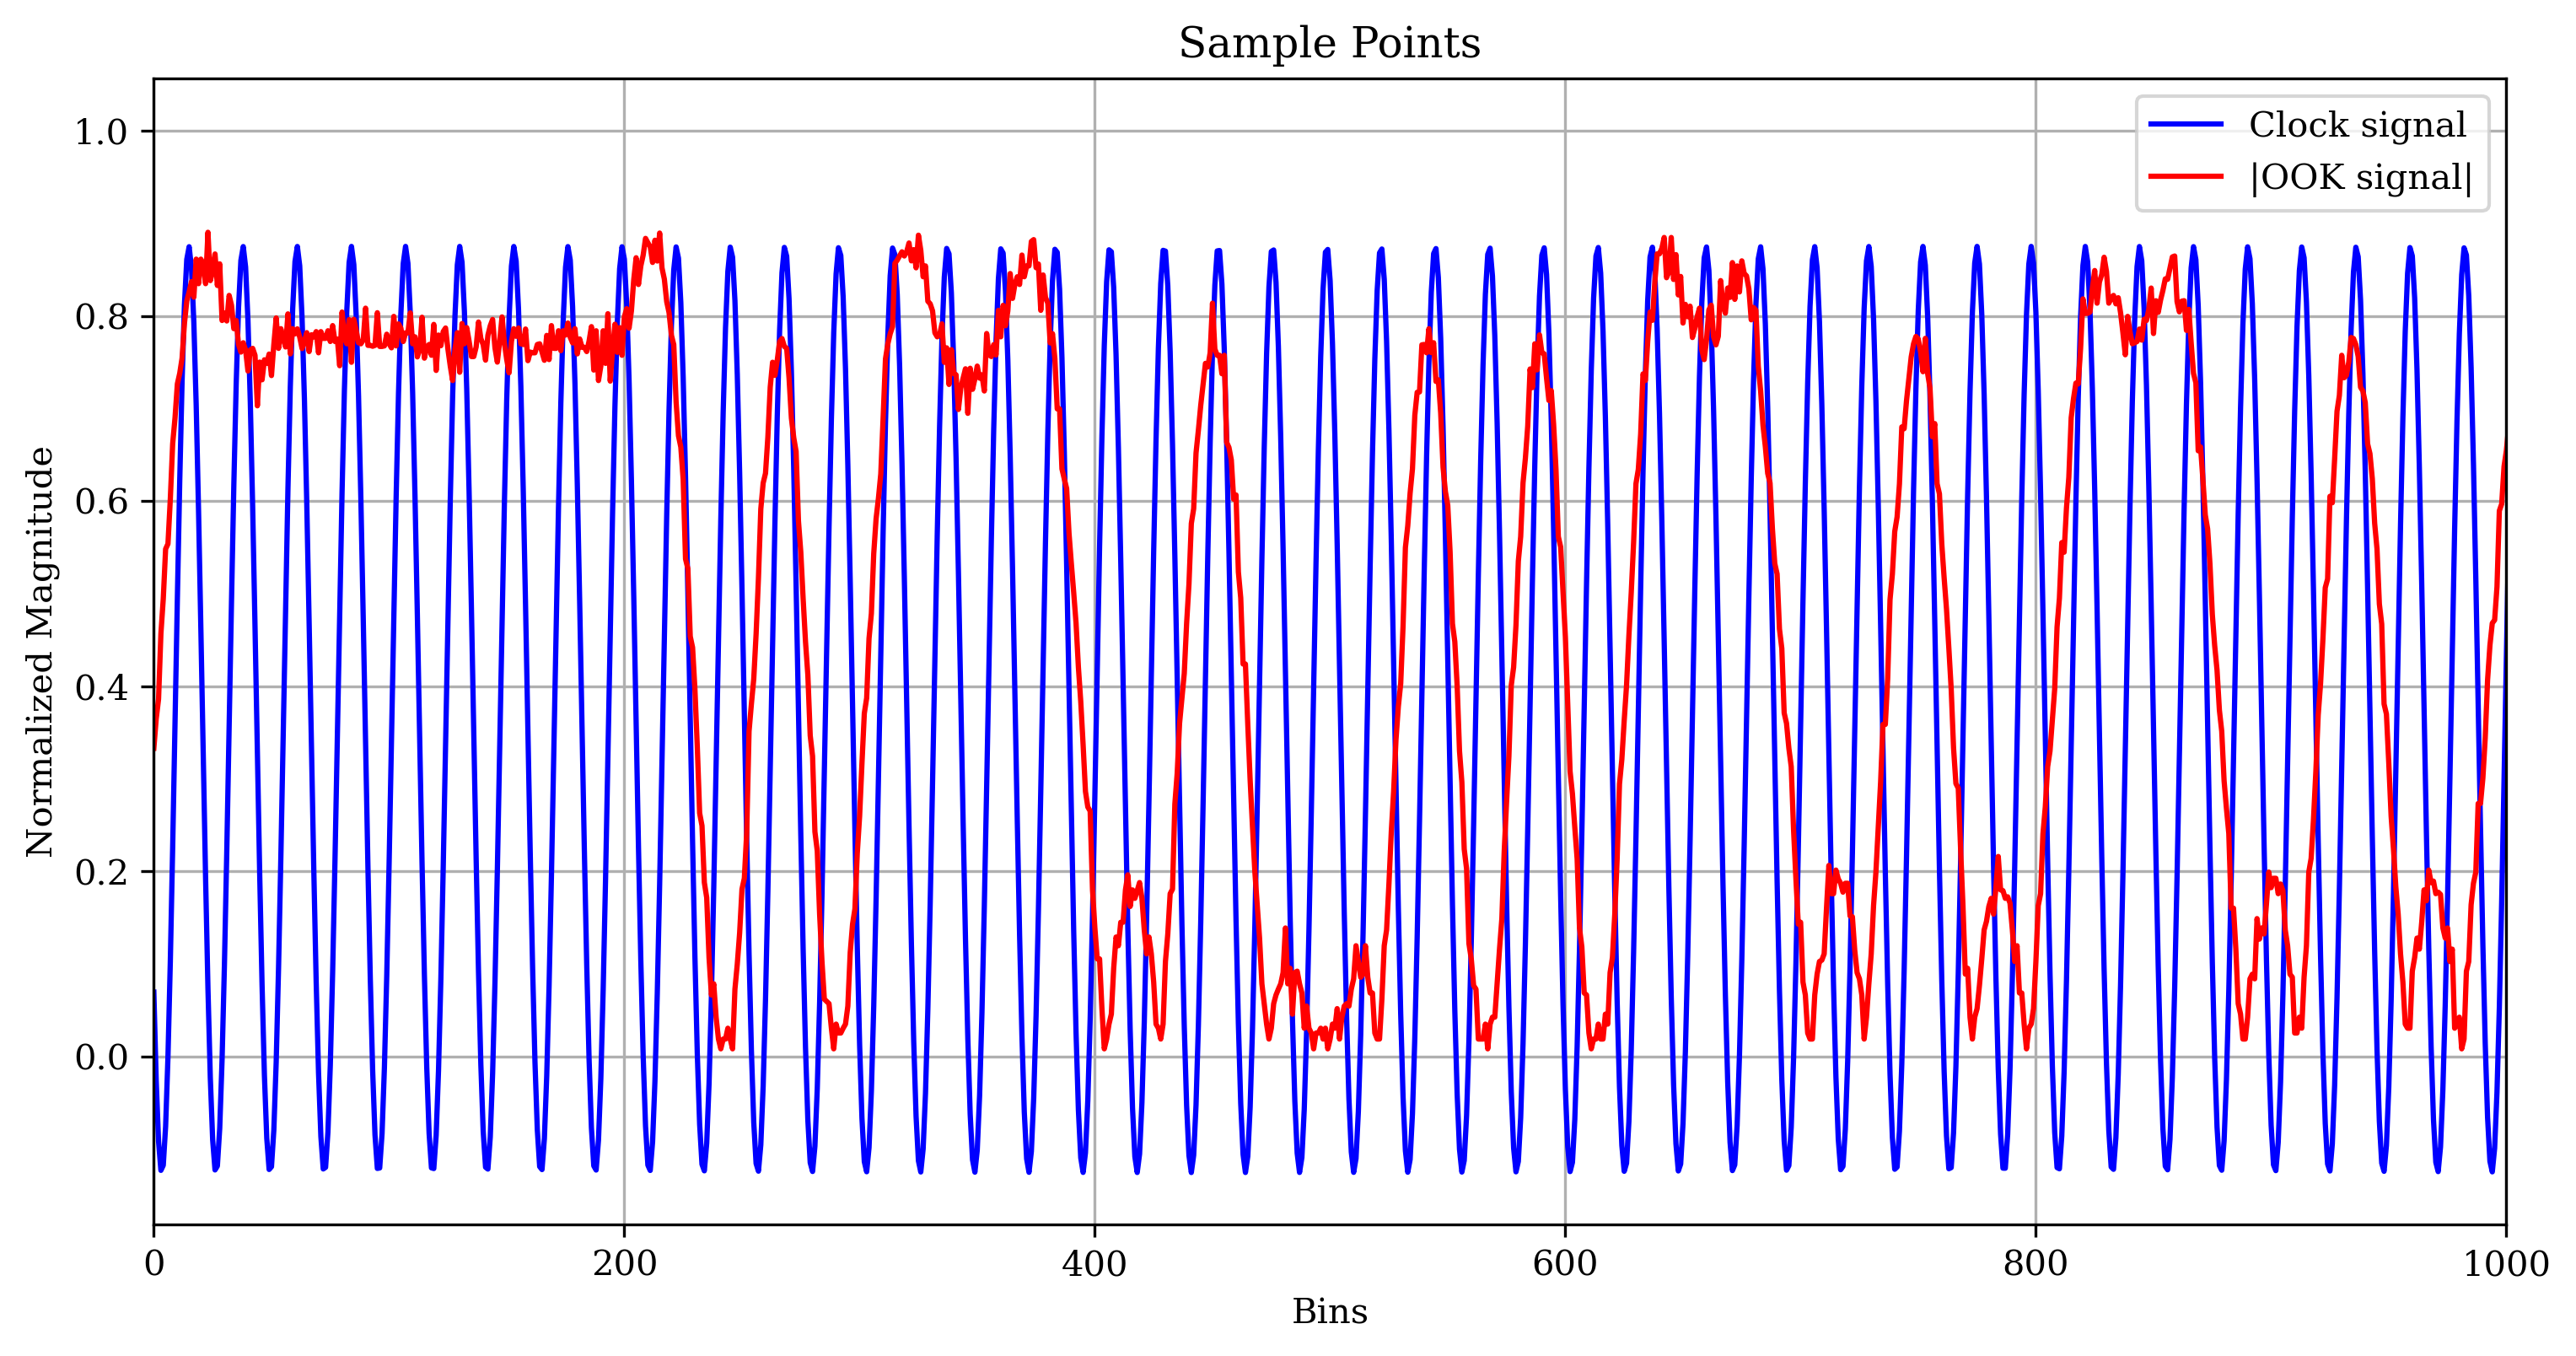

38


In [173]:
#Thus we obtain the frequency of the clock by looking for the largest spike above the noise.
Index_max = 800+(OOK_MAG_ABS[800:1200].argmax())
f_clk=freq[Index_max]
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
f_clk = freq[freq_bin]*2*np.pi
f_clk = f_clk
Φ = OOK_SIGNAL_Φ[freq_bin]
print('Clock Frequency:',f_clk,'Hz')
print('Φ:',Φ,'radians')
print('bin:',freq_bin)

#Creation of the clock signal
clock_signal = np.real(np.exp(1j*((f_clk*t) + Φ)))
clock_signal = (clock_signal+0.75)/2

#Plot the clock with |OOK_signal|
plt.figure(5)
plt.plot(bins,clock_signal,'b',label='Clock signal')
plt.plot(bins,np.abs(OOK_signal),'r',label='|OOK signal|')
plt.xlim(0,len(OOK_signal))
plt.title("Sample Points")
plt.xlabel("Bins")
plt.ylabel("Normalized Magnitude")
plt.legend(loc='upper right')
plt.xlim(0,1000)
#plt.ylim(0.0,0.9)
plt.grid()
plt.show()

### Downsampling the data
The data now needs to sampled at those points this is done everythime the clock signal is at it peak

In [206]:
#Extracting the down sampled data
def f(x):
    f_clk = freq[freq_bin]*2*np.pi
    Φ = OOK_SIGNAL_Φ[freq_bin]
    clock_signal = np.real(np.exp(1j*((f_clk*t) + Φ)))
    Φ = OOK_SIGNAL_Φ[freq_bin]
    ω = freq[freq_bin]*2*np.pi
    BW = 0.3
    diff=[]
    phase=[]
    symbol_data = []
    peak_bins = sp.find_peaks(clock_signal)
    length = len(peak_bins[0])

    for k in peak_bins[0]:
        symbol_data.append(OOK_signal[k])
    sym_length = len(symbol_data) - 2
    i=0
    while  i < length:
        ΔΦ = np.angle(symbol_data[i]*np.conj(clock_signal[peak_bins[0][i]]))
        ω += ΔΦ*BW
        Φ += x*BW * ΔΦ * ω
        diff.append(ω)
        phase.append(Φ)
        clock_signal[i+1] = np.real(np.exp(1j*(ω*t[i+1] + Φ)))
        peak_bins = sp.find_peaks(clock_signal)
        length = len(peak_bins[0])
        if sym_length < i:
            symbol_data.append(OOK_signal[peak_bins[0][i]])
        else:
            symbol_data[i] = (OOK_signal[peak_bins[0][i]])
        i +=1
    #print(i,length,len(symbol_data))
#Normalizing the data
    #OOK_I_Symbol = np.real(symbol_data) / np.abs(symbol_data).max()
    #OOK_Q_Symbol = np.imag(symbol_data)/ np.abs(symbol_data).max()  
    #symbol_data = OOK_I_Symbol + 1j*OOK_Q_Symbol

    #plt.figure(6)
#plt.plot(diff)
    #plt.plot(phase)
    #plt.grid()
    #plt.show()

    plt.figure(7)
    plt.scatter(np.real(symbol_data), np.imag(symbol_data),linewidths=0.1,facecolors='b', edgecolors='b')
    plt.xlabel("In-Phase") 
    plt.ylabel("Quadrature")
    plt.title("OOK: Scatter plot, downsampled")
    plt.grid()
    plt.show()
interact(f,x=(0,0.1,0.0001))

interactive(children=(FloatSlider(value=0.05, description='x', max=0.1, step=0.0001), Output()), _dom_classes=…

<function __main__.f(x)>

### Fine freqency Tuning

As one can see from the scatter plot generated in figure(6) there is still a freqency offset that needs to be corrected

This is done in exactly the same mannor as the corse freqency offset except the time between samples is now the time between the peaks of the cosine clock that was generated erarlier.

In [40]:
### DFT before correction
OOK_O = np.fft.fft(symbol_data)
OOK_MAG_O = 10*np.log10(np.abs(OOK_O))

dt_1 = 1/(f_clk) #Timestep between samples
freq_1 = np.fft.fftfreq(len(symbol_data),dt_1)
bins=np.arange(0,len(symbol_data),1)
t=bins*dt


Δ_f = 5349
symbol_data_off = symbol_data*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))
symbol_data_off = symbol_data_off * np.e**(-1j*np.angle(symbol_data[0]))
print("Fine Frequency Offset:",Δ_f,'Hz')


### DFT aftercorrection
OOK = np.fft.fft(symbol_data_off)
OOK_MAG = 10*np.log10(np.abs(OOK))

#Plotting the results

plt.figure(7)
plt.plot(freq_1,OOK_MAG_O,'r',label='Before Δf correction')
plt.plot(freq_1,OOK_MAG,'b',label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of OOK_signal before and after frequency offset correction")
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.figure(8)
plt.scatter(np.real(symbol_data_off), np.imag(symbol_data_off),linewidths=0.1,facecolors='r', edgecolors='b')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("OOK: Scatter plot, downsampled and frequency corrected")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid()
plt.show()

Fine Frequency Offset: 5349 Hz


### Demodulation 

Now that the freqency offset has been corrected the data may be decoded

In [ ]:
real_symbol = np.real(symbol_data_off)
real_symbol=real_symbol[10:len(real_symbol):1]
data=[]
for i, j in enumerate(real_symbol):
    if  0.5 > j :
        data.append(0)
    if  0.5 < j :
        data.append(1)
print(*data,sep='')
data=data[0:len(data)-3:1]
data=np.reshape(data,(-1,8))
for i in range(113):
        print(data[i,0],data[i,1],data[i,2],data[i,3],data[i,4],data[i,5],data[i,6],data[i,7],sep='')

## 4-ASK
### Splicing of the data

In [103]:
#Splicing of the data
ASK_I = I_samples[ASK_start:ASK_end]
ASK_Q = Q_samples[ASK_start:ASK_end]
ASK_mag = np.abs(complex_data)[ASK_start:ASK_end]

#Normalizing the data
ASK_I = ASK_I / ASK_mag.max()
ASK_Q = ASK_Q / ASK_mag.max()

ASK_signal = ASK_I + 1j*ASK_Q

#Scatter Plot of the ASK data.
plt.figure(1)
plt.scatter(np.real(ASK_signal), np.imag(ASK_signal),facecolors='none', edgecolors='r') 
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("ASK_Signal: Scatter plot")
plt.grid()
plt.show()

### Creating frequency and time arrays

In [104]:
#create a freqency array
dt=1/2.4E6
freq = np.fft.fftfreq(len(ASK_signal),dt)
#create a time array
bins=np.arange(0,len(ASK_signal),1)
t=bins*dt

### Plotting |ASK_signal|

In [105]:
plt.figure(2)
plt.plot(bins,np.abs(ASK_signal))
plt.xlabel("bins") 
plt.ylabel("Normalized Magnitude")
plt.title("Plot of the magnitude of ASK")
plt.grid()
plt.show()

### Plotting the FFT of ASK_signal and doing corse correction of the frequency offset
Since it is given that the first 10 symbols of the signal are used for syncroization and contain no information it is possible to do a corse frequency offset corrrection by obtaining the median between the phase differnece of these samples

$$ \Delta\Phi = \Phi_{2} - \Phi_{1}$$
since we know that the $\Delta\Phi$ is related to $\Delta f$ by the following equation,
$$\Delta f = \frac{median(\Delta\Phi)}{2 \pi \Delta t} $$

Once one has aquired $\Delta f$ in order to correct the freqency offset one needs to multiply by a complex sinusoide in order to correct the offset this is done acording to the equation below

$$ s(t) \cdot e^{j(\omega_{c}+\omega_{o})\cdot t} \cdot e^{-j\omega_{o}} $$

where $\omega_{o}$ is the offset and $\omega_{c}$ is the carrier thus the following result is obtained

$$ s(t) \cdot e^{j(\omega_{c}+\omega_{o} - \omega_{o})\cdot t} $$

$$ s(t) \cdot e^{j(\omega_{c})t} $$

As one can see the offset has been removed

In [106]:
#FFT before corse frequency correction 
ASK_SIGNAL_O = np.fft.fft(ASK_signal)
ASK_MAG_O = 10*np.log10(np.abs(ASK_SIGNAL_O))


Δ_Φ = np.diff(np.unwrap((np.angle(ASK_signal[2:227]))))
Δ_f = np.median(Δ_Φ)  / (np.pi*2*dt)  
print(" Corse Frequency Offset:",Δ_f,'Hz')

#FFT after corse frequency correction
ASK_signal = ASK_signal*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))

ASK_SIGNAL = np.fft.fft(ASK_signal)
ASK_MAG = 10*np.log10(np.abs(ASK_SIGNAL))

#Plotting the results

plt.figure(2)
plt.plot(freq,ASK_MAG_O,'r',label='Before Δf correction')
plt.plot(freq,ASK_MAG,'b',label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of ASK_signal before and after frequency offset correction")
plt.legend(loc='upper right')
plt.ylim(0,ASK_MAG_O.max())
plt.grid()
plt.show()

 Corse Frequency Offset: -343592.17409632 Hz


### Downsampling of the data

The recived data now needs to be downsampled this means that the data only contains symbols at certain increments and thus we need to obtain the frequency and phase of the ogrinal sampling clock in order to reproduce the the sampling clock and syncronise with the symbols.
<br>
This is done by taking the DFT|data| by taking the DFT of the absolute one removes the frequency and phase offset.
<br>
Since it is provided that the system has a symbol rate of around 100,000 symbols per second then a large oberservable spike should accour at around that point.
<br>
*[Note] It is not at exactly 100 kHz because there is error in the local oscilator in the SDR, therefore it does not match up exactly

In [107]:
#DFT of |ASK_signal|
ASK_SIGNAL_ABS = np.fft.fft(np.abs(ASK_signal))
ASK_MAG_ABS = 10*np.log10(np.abs(ASK_SIGNAL_ABS))
ASK_SIGNAL_Φ = np.unwrap(np.angle(ASK_SIGNAL_ABS))

plt.figure(3)
plt.plot(freq,ASK_MAG_ABS)
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of |ASK_signal|")
plt.xlim(-1,freq.max())
plt.grid()
plt.show()

plt.figure(4)
plt.plot(bins,ASK_MAG_ABS)
plt.xlabel("bins") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of |ASK_signal|")
plt.xlim(0,bins.max())
plt.grid()
plt.show()

Once the frequency spike(which represents the data) is located one may also optain the $\Phi_{clock}$ by the following equation
$$\Phi_{clock} = tan^{-1}(Q/I)$$ where Q and I are the compents at the freqency spike.

In [108]:
#Thus we obtain the frequency of the clock by lASKing for the largest spike above the noise.
Index_max = 800+(ASK_MAG_ABS[800:1200].argmax())
f_clk=freq[Index_max]
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
f_clk = freq[freq_bin]
Φ =ASK_SIGNAL_Φ[freq_bin]

print('Clock Frequency:',f_clk,'Hz')
print('Φ:',Φ,'radians')
print('bin:',freq_bin)

#Creation of the clock signal
clock_signal = np.cos((2*np.pi*t*f_clk)+Φ)
clock_signal = (clock_signal+1)/2

#Plot the clock with |ASK_signal|
plt.figure(6)
plt.plot(bins,clock_signal,'r',label='Clock signal')
plt.plot(bins,np.abs(ASK_signal),'b',label='|ASK signal|')
plt.xlim(0,len(ASK_signal))
plt.title("Sample Points")
plt.xlabel("Bins")
plt.ylabel("Normalized Magnitude")
plt.legend(loc='upper right')
plt.grid()
plt.show()

Clock Frequency: 94920.03762935089 Hz
Φ: 80.70754281756241 radians
bin: 1009


### Downsampling the data
The data now needs to sampled at those points this is done everythime the clock signal is at it peak

In [109]:
#Extracting the down sampled data
symbol_data = []
peak_bins = sp.find_peaks(clock_signal)
for i in peak_bins[0]:
    symbol_data.append(ASK_signal[i])
    
#Normalizing the data
ASK_I_Symbol = np.real(symbol_data) / np.abs(symbol_data).max()
ASK_Q_Symbol = np.imag(symbol_data)/ np.abs(symbol_data).max()  
symbol_data = ASK_I_Symbol + 1j*ASK_Q_Symbol

plt.figure(7)
plt.scatter(np.real(symbol_data), np.imag(symbol_data),linewidths=0.1,facecolors='r', edgecolors='b')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("ASK: Scatter plot, downsampled")
plt.grid()
plt.show()

### Fine freqency Tuning

As one can see from the scatter plot generated in figure(6) there is still a freqency offset that needs to be corrected

This is done in exactly the same mannor as the corse freqency offset except the time between samples is now the time between the peaks of the cosine clock that was generated erarlier.

In [127]:
### DFT before correction
ASK_O = np.fft.fft(symbol_data)
ASK_MAG_O = 10*np.log10(np.abs(ASK_O))

dt = 1/(f_clk) #Timestep between samples
freq = np.fft.fftfreq(len(symbol_data),dt)
bins=np.arange(0,len(symbol_data),1)
t=bins*dt


Δ_f = 45782.05
symbol_data_off = symbol_data*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))
symbol_data_off = symbol_data_off * np.e**(-1j*np.angle(symbol_data_off[1]))

### DFT aftercorrection
ASK = np.fft.fft(symbol_data_off)
ASK_MAG = 10*np.log10(np.abs(ASK))

#Plotting the results

plt.figure(8)
plt.plot(freq,ASK_MAG_O,'r',label='Before Δf correction')
plt.plot(freq,ASK_MAG,'b',label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of ASK_signal before and after frequency offset correction")
plt.legend(loc='upper right')
plt.grid()
plt.show()

plt.figure(9)
#plt.scatter(np.real(symbol_data_off), np.imag(symbol_data_off),linewidths=0.1,facecolors='none', edgecolors='b')
plt.scatter(np.real(symbol_data_off[8]), np.imag(symbol_data_off[8]),linewidths=0.1,facecolors='g', edgecolors='g')
plt.scatter(np.real(symbol_data_off[9]), np.imag(symbol_data_off[9]),linewidths=0.1,facecolors='r', edgecolors='r')
plt.scatter(np.real(symbol_data_off[10]), np.imag(symbol_data_off[10]),linewidths=0.1,facecolors='b', edgecolors='b')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("ASK: Scatter plot, downsampled")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid()
plt.show()

### Demodulation 

Now that the freqency offset has been corrected the data may be decoded

In [125]:
real_symbol=np.real(symbol_data_off)
real_symbol=real_symbol[10:len(real_symbol):1]
data=[]
for i, j in enumerate(real_symbol):
    if  -1 <j < - 0.5:
        data.append(0)
        data.append(0)
    if -0.5 < j < 0:
        data.append(0)
        data.append(1)
    if 0 < j < 0.5:
        data.append(1)
        data.append(1)
    if 0.5 < j < 1:
        data.append(1)
        data.append(0) 
print(*data,sep='')

0111110001101111010110110000001001001111010011010101011001001010010001110101000000000010010101110101000101000111010001100000001001010110010011010000001001001111010000110100100101000111000000100100111101000111000000100101010101000011010011100100100100000010010101100100101001000111000000100101001001001110010000110100110001001001000000100101010101001010010001110100110000000010011010110000001001010101010000110101000100000010010110110100110101010111010011000100010101000111010100000000001001000000010001110100000101000011010101110101000101000111000000100101010101000111000000100100000101001101010101110100111001000110010011000000010101010110000000100100001101000100010001000100110101010000010001100000001001000011000000100100011001001101010001010000110000000110001010001100001010010010010111000100011110011100101001101000010100000101011000100000110010001000011111101101100111100001010110000011110100000100001001100110100000010111010000000010101010000010101001111111010001101100110011010100110000011101

# PSK
## DBPSK

In [130]:
#Splicing of the data
DBPSK_I = I_samples[DBPSK_start:DBPSK_end]
DBPSK_Q = Q_samples[DBPSK_start:DBPSK_end]
DBPSK_mag = np.abs(complex_data)[DBPSK_start:DBPSK_end]

#Normalizing the data
DBPSK_I = DBPSK_I / DBPSK_mag.max()
DBPSK_Q = DBPSK_Q / DBPSK_mag.max()

DBPSK_signal = DBPSK_I + 1j*DBPSK_Q

#Scatter Plot of the DBPSK data.
f1, ax1 = plt.subplots(1,1)
ax1.xaxis.set_major_formatter(formatter0)
ax1.scatter(np.real(DBPSK_signal), np.imag(DBPSK_signal),facecolors='none', edgecolors='r') 
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.grid()
plt.show()

#create a freqency array
fs = 2.4E6
freq = np.fft.fftfreq(len(DBPSK_signal),dt)

#create a time array
bins=np.arange(0,len(DBPSK_signal),1)
t=bins*dt

f2, ax2 = plt.subplots(1,1)
ax2.xaxis.set_major_formatter(formatter0)
ax2.plot(bins,np.abs(DBPSK_signal),'r')
plt.xlabel("bins") 
plt.ylabel("Normalized Magnitude")
plt.grid()
plt.show()

#FFT before corse frequency correction 
DBPSK_SIGNAL_O = np.fft.fft(DBPSK_signal)
DBPSK_MAG_O = 10*np.log10(np.abs(DBPSK_SIGNAL_O))


Δ_Φ = np.diff(np.unwrap((np.angle(DBPSK_signal[2:227]))))
Δ_f = np.median(Δ_Φ)  / (np.pi*2*dt)  
print(" Corse Frequency Offset:",Δ_f,'Hz')

#FFT after corse frequency correction
DBPSK_signal = DBPSK_signal*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))

DBPSK_SIGNAL = np.fft.fft(DBPSK_signal)
DBPSK_MAG = 10*np.log10(np.abs(DBPSK_SIGNAL))

#Plotting the results

f3, ax3 = plt.subplots(1,1)
ax3.xaxis.set_major_formatter(formatter0)
ax3.plot(freq,DBPSK_MAG_O,'r',label='Before Δf correction')
ax3.plot(freq,DBPSK_MAG,'b',label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.legend(loc='upper right')
plt.ylim(0,DBPSK_MAG_O.max())
plt.grid()
plt.show()

#DFT of |DBPSK_signal|
DBPSK_SIGNAL_ABS = np.fft.fft(np.abs(DBPSK_signal))
DBPSK_MAG_ABS = 10*np.log10(np.abs(DBPSK_SIGNAL_ABS))
DBPSK_SIGNAL_Φ = np.angle(DBPSK_SIGNAL_ABS)

f4, ax4 = plt.subplots(1,1)
ax4.xaxis.set_major_formatter(formatter0)
ax4.plot(freq,DBPSK_MAG_ABS,'r')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.xlim(0,freq.max())
plt.grid()
plt.show()

#Thus we obtain the frequency of the clock by lDBPSKing for the largest spike above the noise.
Index_max = 800+(DBPSK_MAG_ABS[800:1200].argmax())
f_clk=freq[Index_max]
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
f_clk = freq[freq_bin]
Φ =DBPSK_SIGNAL_Φ[freq_bin]
print('Clock Frequency:',f_clk,'Hz')
print('Φ:',Φ,'radians')
print('bin:',freq_bin)


#Creation of the clock signal
clock_signal = np.cos((2*np.pi*t*f_clk)+Φ)
clock_signal = (clock_signal+1)/2

#Plot the clock with |DBPSK_signal|
f5, ax5 = plt.subplots(1,1)
ax5.plot(bins,clock_signal,'r',label='Clock signal')
ax5.plot(bins,np.abs(DBPSK_signal),'b',label='|DBPSK signal|')
plt.xlim(0,len(DBPSK_signal))
plt.xlabel("Bins")
plt.ylabel("Normalized Magnitude")
plt.legend(loc='upper right')
plt.grid()
plt.show()

#Extracting the down sampled data
symbol_data = []
peak_bins = sp.find_peaks(clock_signal)
for i in peak_bins[0]:
    symbol_data.append(DBPSK_signal[i])
    
#Normalizing the data
DBPSK_I_Symbol = np.real(symbol_data) / np.abs(symbol_data).max()
DBPSK_Q_Symbol = np.imag(symbol_data)/ np.abs(symbol_data).max()  
symbol_data = DBPSK_I_Symbol + 1j*DBPSK_Q_Symbol

f6, ax6 = plt.subplots(1,1)
ax6.scatter(np.real(symbol_data), np.imag(symbol_data),linewidths=0.1,facecolors='r', edgecolors='b')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.grid()
plt.show()

### DFT before correction
DBPSK_O = np.fft.fft(symbol_data)
DBPSK_MAG_O = 10*np.log10(np.abs(DBPSK_O))

dt_1 = 1/(f_clk) #Timestep between samples
freq_1 = np.fft.fftfreq(len(symbol_data),dt_1)
bins=np.arange(0,len(symbol_data),1)
t=bins*dt


Δ_f=freq[DBPSK_MAG_O.argmax()]
symbol_data_off = symbol_data*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))
print(" Corse Frequency Offset:",Δ_f,'Hz')

### DFT aftercorrection
DBPSK = np.fft.fft(symbol_data_off)
DBPSK_MAG = 10*np.log10(np.abs(DBPSK))

#Plotting the results

f7, ax7 = plt.subplots(1,1)
ax7.xaxis.set_major_formatter(formatter0)
ax7.plot(freq_1,DBPSK_MAG_O,'r',label='Before Δf correction')
ax7.plot(freq_1,DBPSK_MAG,'b',label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.legend(loc='upper right')
plt.grid()
plt.show()

Δ_f = -534
symbol_data_off = symbol_data*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))
symbol_data_off = symbol_data_off * np.e**(-1j*np.angle(symbol_data[1]))


f8, ax8 = plt.subplots(1,1)
ax8.scatter(np.real(symbol_data_off), np.imag(symbol_data_off),linewidths=0.1,facecolors='r', edgecolors='b')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid()
plt.show()

Δ_Φ = np.abs(np.diff((np.angle(symbol_data_off,deg='True'))))
Δ_Φ=Δ_Φ[9:len(Δ_Φ)]
data=[]
for i in range(len(Δ_Φ)):
    if 100 < Δ_Φ[i] < 260:
        data.append(1)
    else:
        data.append(0)
        
print(*data,sep='')
data=data[0:len(data):1]
data=np.reshape(data,(-1,8))
#for i in range(113):
        #print(data[i,0],data[i,1],data[i,2],data[i,3],data[i,4],data[i,5],data[i,6],data[i,7],sep='')

 Corse Frequency Offset: -3747.456107551914 Hz
Clock Frequency: 3802.8257836431735 Hz
Φ: 1.7776543035877206 radians
bin: 1010
 Corse Frequency Offset: 760.5651567286346 Hz
010111100100111101101110001000000111010001101000011001010010000001101111011101000110100001100101011100100010000001101000011000010110111001100100001011000010000001111001011011110111010100100000011010000110000101110110011001010010000001100100011010010110011001100110011001010111001001100101011011100111010000100000011001100110100101101110011001110110010101110010011100110010111000100100101110101111000110001011001001101001011100110101011101000010111110001000101110111011010111001010010100011010101010110001110011010110100000101001001011100110010101110011101010100000010010111010111101111100011001001100010001110001101001010010111010111101110011100011011010100010011011101110000100000111010111101111110000101011011010011111111011000001110111000000001111100001111100110111101111011111000010000110001010001110100101010100100100101000

## DQPSK

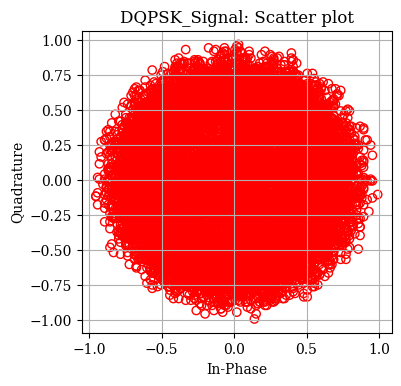

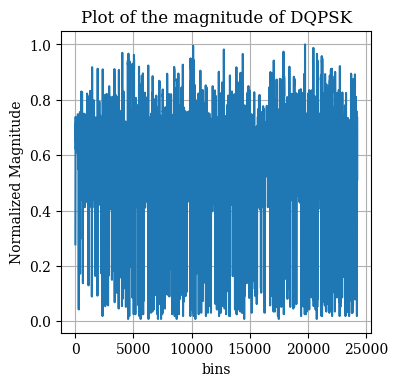

 Corse Frequency Offset: 154566.9039847283 Hz


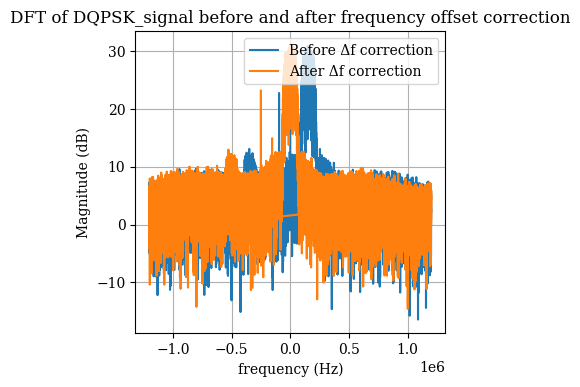

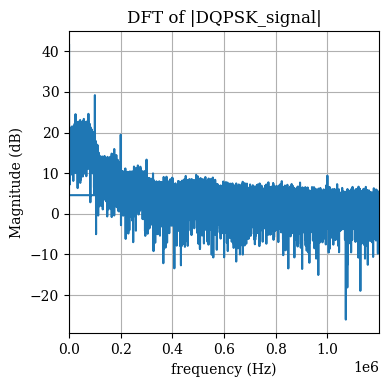

Clock Frequency: 99979.37719117344 Hz
Φ: 3.075063584616584 radians
bin: 1010


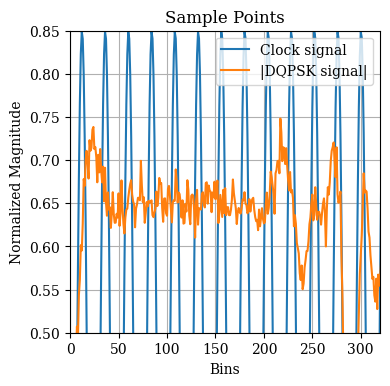

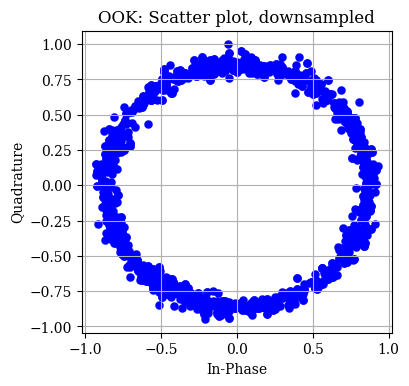

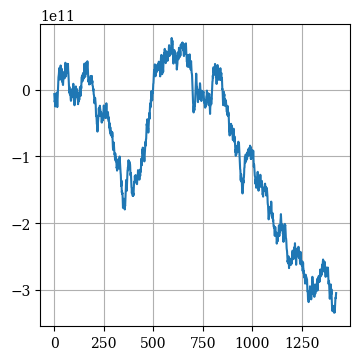

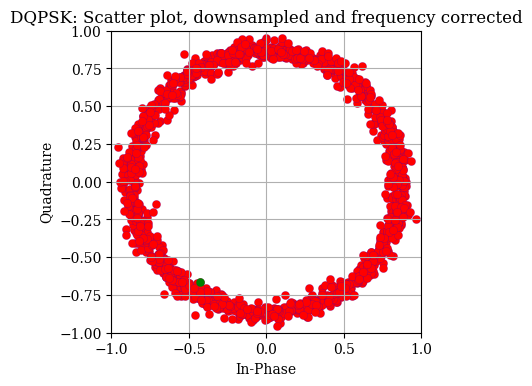

In [296]:
#Splicing of the data
DQPSK_I = I_samples[DQPSK_start:DQPSK_end]
DQPSK_Q = Q_samples[DQPSK_start:DQPSK_end]
DQPSK_mag = np.abs(complex_data)[DQPSK_start:DQPSK_end]

#Normalizing the data
DQPSK_I = DQPSK_I / DQPSK_mag.max()
DQPSK_Q = DQPSK_Q / DQPSK_mag.max()

DQPSK_signal = DQPSK_I + 1j*DQPSK_Q

#Scatter Plot of the DQPSK data.
plt.figure(1)
plt.scatter(np.real(DQPSK_signal), np.imag(DQPSK_signal),facecolors='none', edgecolors='r') 
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("DQPSK_Signal: Scatter plot")
plt.grid()
plt.show()

#create a freqency array
fs = 2.4E6
freq = np.fft.fftfreq(len(DQPSK_signal),dt)

#create a time array
bins=np.arange(0,len(DQPSK_signal),1)
t=bins*dt

plt.figure(2)
plt.plot(bins,np.abs(DQPSK_signal))
plt.xlabel("bins") 
plt.ylabel("Normalized Magnitude")
plt.title("Plot of the magnitude of DQPSK")
plt.grid()
plt.show()

#FFT before corse frequency correction 
DQPSK_SIGNAL_O = np.fft.fft(DQPSK_signal)
DQPSK_MAG_O = 10*np.log10(np.abs(DQPSK_SIGNAL_O))


Δ_Φ = np.diff(np.unwrap((np.angle(DQPSK_signal[2:227]))))
Δ_f = np.median(Δ_Φ)  / (np.pi*2*dt)  
print(" Corse Frequency Offset:",Δ_f,'Hz')

#FFT after corse frequency correction
DQPSK_signal = DQPSK_signal*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))

DQPSK_SIGNAL = np.fft.fft(DQPSK_signal)
DQPSK_MAG = 10*np.log10(np.abs(DQPSK_SIGNAL))

#Plotting the results

plt.figure(3)
plt.plot(freq,DQPSK_MAG_O,label='Before Δf correction')
plt.plot(freq,DQPSK_MAG,label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of DQPSK_signal before and after frequency offset correction")
plt.legend(loc='upper right')
plt.grid()
plt.show()

#DFT of |DQPSK_signal|
DQPSK_SIGNAL_ABS = np.fft.fft(np.abs(DQPSK_signal))
DQPSK_MAG_ABS = 10*np.log10(np.abs(DQPSK_SIGNAL_ABS))
DQPSK_SIGNAL_Φ = np.angle(DQPSK_SIGNAL_ABS)

plt.figure(4)
plt.plot(freq,DQPSK_MAG_ABS)
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of |DQPSK_signal|")
plt.xlim(0,freq.max())
plt.grid()
plt.show()

#Thus we obtain the frequency of the clock by lDQPSKing for the largest spike above the noise.
Index_max = 800+(DQPSK_MAG_ABS[800:1200].argmax())
f_clk=freq[Index_max]
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
f_clk = freq[freq_bin]
Φ =DQPSK_SIGNAL_Φ[freq_bin]
print('Clock Frequency:',f_clk,'Hz')
print('Φ:',Φ,'radians')
print('bin:',freq_bin)

#Creation of the clock signal
clock_signal = np.cos((2*np.pi*t*f_clk)+Φ)
clock_signal = (clock_signal+0.7)/2

#Plot the clock with |DQPSK_signal|
plt.figure(5)
plt.plot(bins,clock_signal,label='Clock signal')
plt.plot(bins,np.abs(DQPSK_signal),label='|DQPSK signal|')
plt.xlim(0,320)
plt.ylim(0.5,0.85)
plt.title("Sample Points")
plt.xlabel("Bins")
plt.ylabel("Normalized Magnitude")
plt.legend(loc='upper right')
plt.grid()
plt.show()

#Extracting the down sampled data
#Extracting the down sampled data
f_clk = freq[freq_bin]*2*np.pi
Φ = DQPSK_SIGNAL_Φ[freq_bin]
clock_signal = np.exp(1j*((f_clk*t) + Φ))
Φ = DQPSK_SIGNAL_Φ[freq_bin]
ω = freq[freq_bin]*2*np.pi
BW = 300
diff=[]
phase=[]
symbol_data = []
peak_bins = sp.find_peaks(np.real(clock_signal))
length = len(peak_bins[0])

for k in peak_bins[0]:
    symbol_data.append(DQPSK_signal[k])
sym_length = len(symbol_data) - 2
i=0
while  i < length:
    ΔΦ = np.angle(symbol_data[i]*np.conj(clock_signal[peak_bins[0][i]]))
    ω += ΔΦ*BW
    Φ += np.sqrt(BW) * ΔΦ * ω
    diff.append(ω)
    phase.append(Φ)
    clock_signal[i+1] = np.exp(1j*(Δ_f*t[i+1] + Φ))
    peak_bins = sp.find_peaks(np.real(clock_signal))
    length = len(peak_bins[0])
    if sym_length < i:
        symbol_data.append(DQPSK_signal[peak_bins[0][i]])
    else:
        symbol_data[i] = (DQPSK_signal[peak_bins[0][i]])
    i +=1
        
#Normalizing the data
DQPSK_I_Symbol = np.real(symbol_data) / np.abs(symbol_data).max()
DQPSK_Q_Symbol = np.imag(symbol_data)/ np.abs(symbol_data).max()  
symbol_data = DQPSK_I_Symbol + 1j*DQPSK_Q_Symbol
    
plt.figure(6)
plt.scatter(np.real(symbol_data), np.imag(symbol_data),linewidths=0.1,facecolors='b', edgecolors='b')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("OOK: Scatter plot, downsampled")
plt.grid()
plt.show()

dt_1 = 1/(f_clk)
bins=np.arange(0,len(symbol_data),1)
t=bins*dt_1
Φ = 0
ω = 2000
NCO = np.cos(2 * np.pi * ω * (t + Φ))
KP = .05
diff=[]
for i in range (len(t)-1):
    ΔΦ = np.angle(symbol_data[i]*np.conj(NCO[i]))
    Φ += (ΔΦ*KP)/dt_1
    f = Φ/(2*np.pi*dt_1)
    diff.append(f)
    NCO = np.cos(2 * np.pi * ω * (t + Φ))
    symbol_data = symbol_data*(np.cos(2*np.pi*(-1*f)*t) + 1j*np.sin(2*np.pi*(-1*f)*t))
### DFT before correction
DQPSK_O = np.fft.fft(symbol_data)
DQPSK_MAG_O = 10*np.log10(np.abs(DQPSK_O))

dt_1 = 1/(f_clk) #Timestep between samples
freq_1 = np.fft.fftfreq(len(symbol_data),dt_1)
bins=np.arange(0,len(symbol_data),1)
t=bins*dt

#Δ_f=2842.50
#symbol_data_off = symbol_data*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))
#symbol_data_off = symbol_data * np.e**(-1j*np.angle(symbol_data[1]))
symbol_data_off = symbol_data
### DFT aftercorrection
DQPSK = np.fft.fft(symbol_data_off)
DQPSK_MAG = 10*np.log10(np.abs(DQPSK))

#Plotting the results

plt.figure(7)
#plt.plot(freq_1,DQPSK_MAG_O,label='Before Δf correction')
#plt.plot(freq_1,DQPSK_MAG,label='After Δf correction')
plt.plot(diff)
#plt.xlabel("frequency (Hz)") 
#plt.ylabel("Magnitude (dB)")
#plt.title("DFT of DQPSK_signal before and after frequency offset correction")
#plt.legend(loc='upper right')
plt.grid()
plt.show()


plt.figure(8)
plt.scatter(np.real(symbol_data_off), np.imag(symbol_data_off),linewidths=0.1,facecolors='r', edgecolors='b')
plt.scatter(np.real(symbol_data_off[0]), np.imag(symbol_data_off[0]),linewidths=0.1,facecolors='g', edgecolors='g')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("DQPSK: Scatter plot, downsampled and frequency corrected")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid()
plt.show()

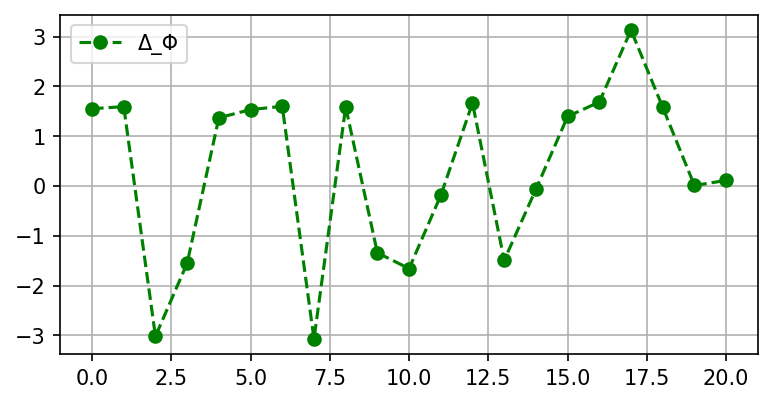

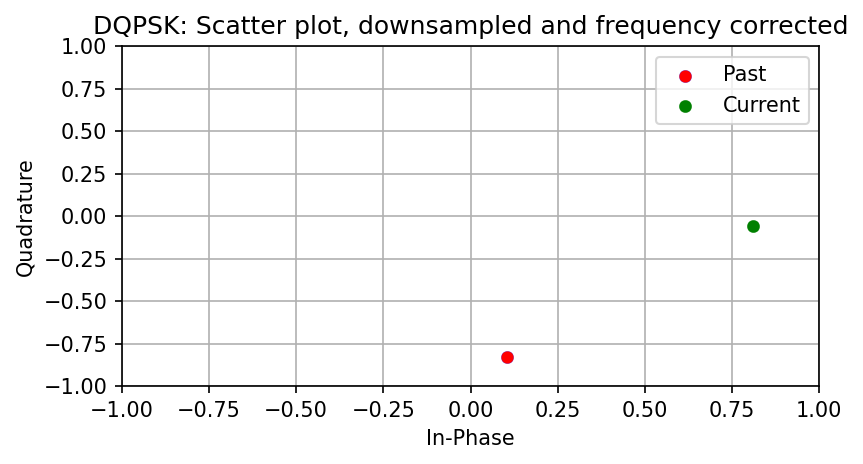

In [295]:
Φ = np.unwrap(np.angle(symbol_data_off)) #* (180/np.pi)
Δ_Φ = np.diff(Φ) 
#plt.plot(Φ[:50],'ro--',label='Φ')
plt.plot(Δ_Φ[9:30],'go--',label='Δ_Φ')
plt.legend()
plt.grid()

plt.figure(8)
plt.scatter(np.real(symbol_data_off[13]), np.imag(symbol_data_off[13]),linewidths=0.1,facecolors='r', edgecolors='b',label='Past')
plt.scatter(np.real(symbol_data_off[14]), np.imag(symbol_data_off[14]),linewidths=0.1,facecolors='g', edgecolors='g',label='Current')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("DQPSK: Scatter plot, downsampled and frequency corrected")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.legend()
plt.grid()
plt.show()


#data=[]
#for i in range(len(Δ_Φ)):
    #if -45 < Δ_Φ[i] < 45:
        #data.append(0)
        #data.append(0)
    #if 45 < Δ_Φ[i] < 135:
        #data.append(0)
        #data.append(1)
    #if 135 < Δ_Φ[i] < 260:
        #data.append(1)
        #data.append(1)
    #if 100 < Δ_Φ[i] < 260:
        #data.append(1)
        #data.append(0)

## D8PSK

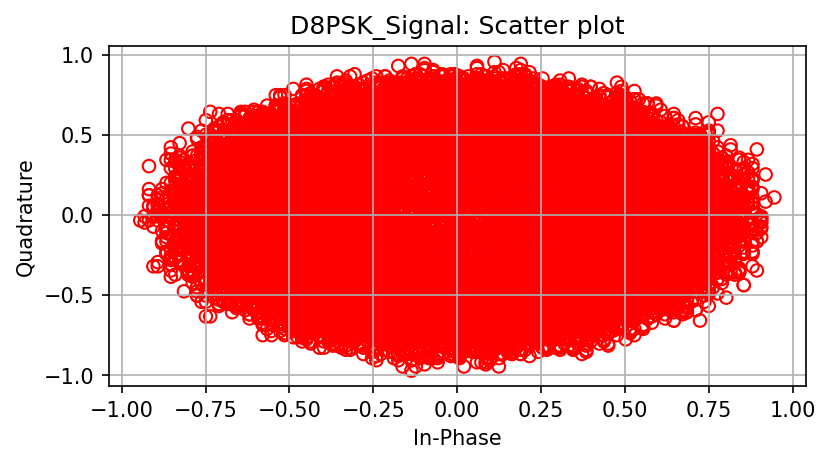

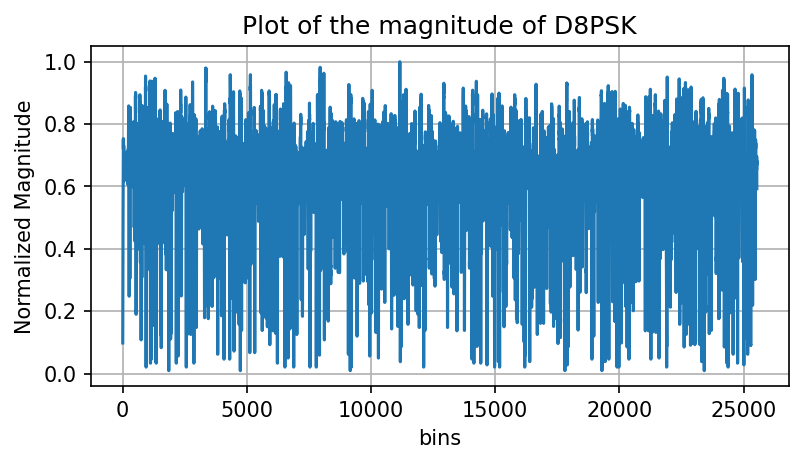

 Corse Frequency Offset: 403596.0408650182 Hz


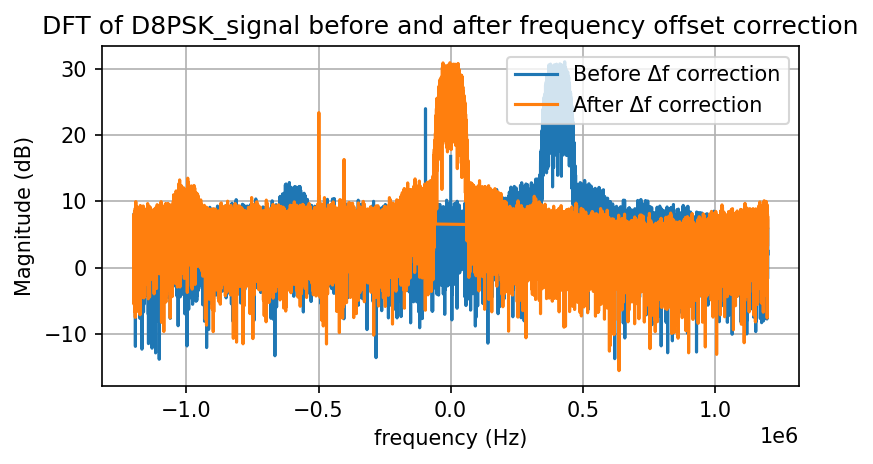

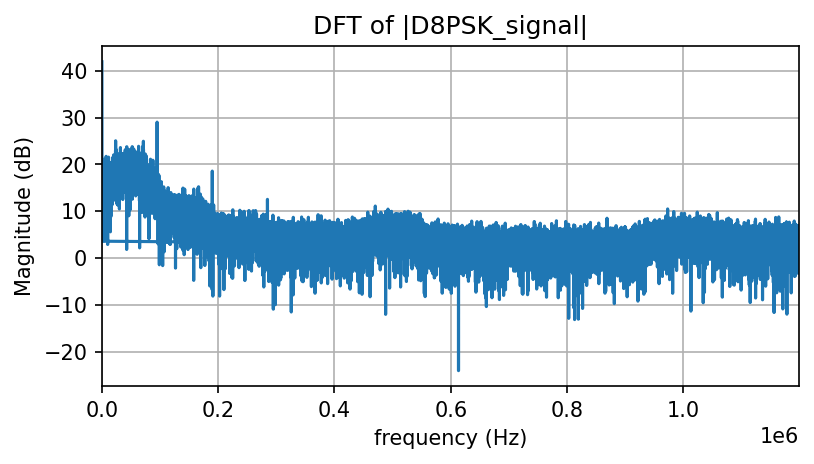

Clock Frequency: 94924.81203007519 Hz
Φ: 1.4249170169505958 radians
bin: 1010


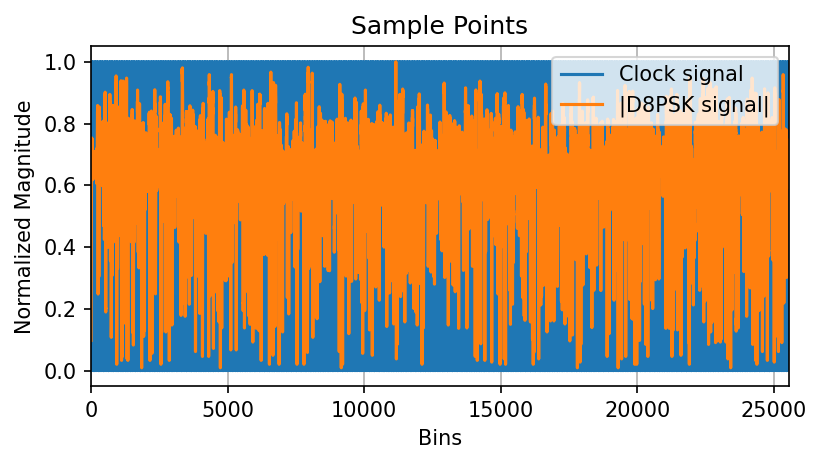

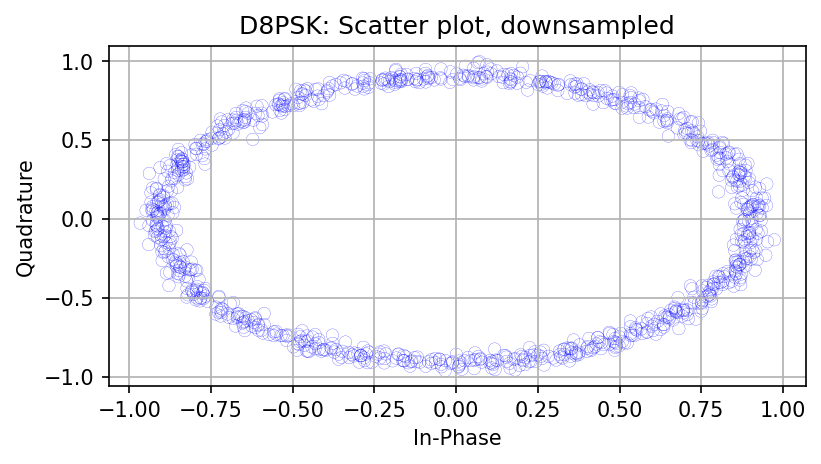

 Corse Frequency Offset: 26920.6 Hz


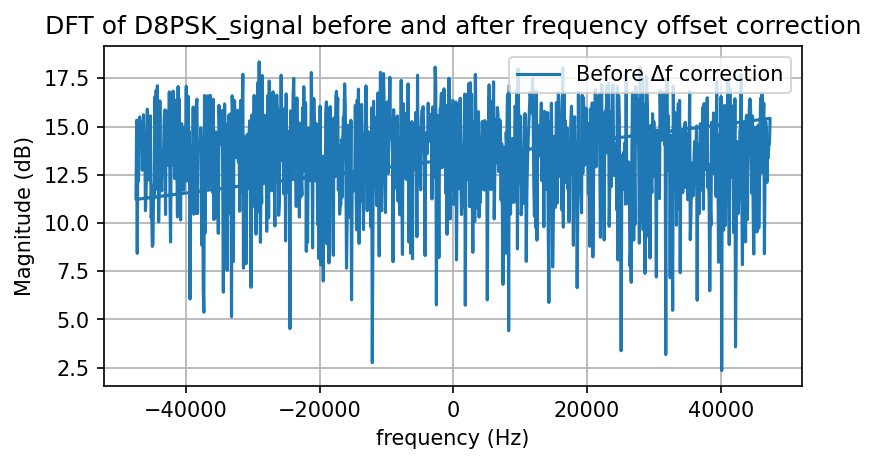

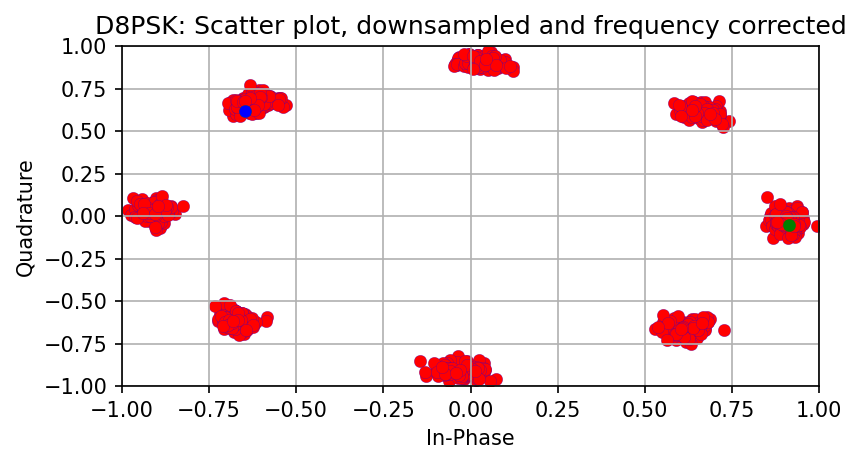

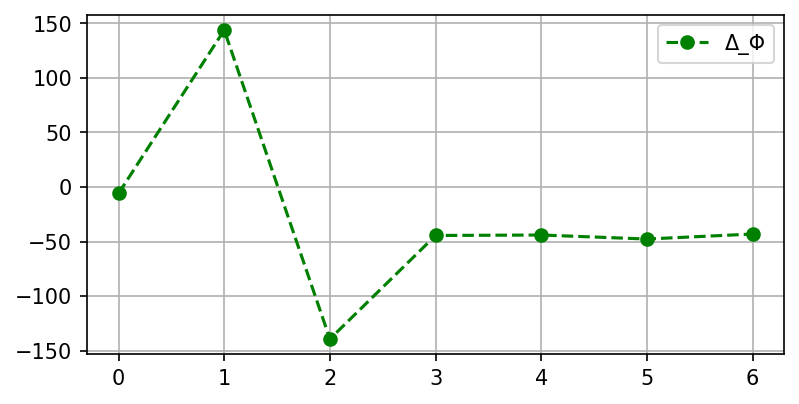

In [284]:
#Splicing of the data
D8PSK_I = I_samples[D8PSK_start:D8PSK_end]
D8PSK_Q = Q_samples[D8PSK_start:D8PSK_end]
D8PSK_mag = np.abs(complex_data)[D8PSK_start:D8PSK_end]

#Normalizing the data
D8PSK_I = D8PSK_I / D8PSK_mag.max()
D8PSK_Q = D8PSK_Q / D8PSK_mag.max()

D8PSK_signal = D8PSK_I + 1j*D8PSK_Q

#Scatter Plot of the D8PSK data.
plt.figure(1)
plt.scatter(np.real(D8PSK_signal), np.imag(D8PSK_signal),facecolors='none', edgecolors='r') 
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("D8PSK_Signal: Scatter plot")
plt.grid()
plt.show()

#create a freqency array
fs = 2.4E6
freq = np.fft.fftfreq(len(D8PSK_signal),dt)

#create a time array
bins=np.arange(0,len(D8PSK_signal),1)
t=bins*dt

plt.figure(2)
plt.plot(bins,np.abs(D8PSK_signal))
plt.xlabel("bins") 
plt.ylabel("Normalized Magnitude")
plt.title("Plot of the magnitude of D8PSK")
plt.grid()
plt.show()

#FFT before corse frequency correction 
D8PSK_SIGNAL_O = np.fft.fft(D8PSK_signal)
D8PSK_MAG_O = 10*np.log10(np.abs(D8PSK_SIGNAL_O))


Δ_Φ = np.diff(np.unwrap((np.angle(D8PSK_signal[2:227]))))
Δ_f = np.median(Δ_Φ)  / (np.pi*2*dt)  
print(" Corse Frequency Offset:",Δ_f,'Hz')

#FFT after corse frequency correction
D8PSK_signal = D8PSK_signal*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))

D8PSK_SIGNAL = np.fft.fft(D8PSK_signal)
D8PSK_MAG = 10*np.log10(np.abs(D8PSK_SIGNAL))

#Plotting the results

plt.figure(3)
plt.plot(freq,D8PSK_MAG_O,label='Before Δf correction')
plt.plot(freq,D8PSK_MAG,label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of D8PSK_signal before and after frequency offset correction")
plt.legend(loc='upper right')
plt.grid()
plt.show()

#DFT of |D8PSK_signal|
D8PSK_SIGNAL_ABS = np.fft.fft(np.abs(D8PSK_signal))
D8PSK_MAG_ABS = 10*np.log10(np.abs(D8PSK_SIGNAL_ABS))
D8PSK_SIGNAL_Φ = np.angle(D8PSK_SIGNAL_ABS)

plt.figure(4)
plt.plot(freq,D8PSK_MAG_ABS)
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of |D8PSK_signal|")
plt.xlim(0,freq.max())
plt.grid()
plt.show()

#Thus we obtain the frequency of the clock by lD8PSKing for the largest spike above the noise.
Index_max = 800+(D8PSK_MAG_ABS[800:1200].argmax())
f_clk=freq[Index_max]
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
f_clk = freq[freq_bin]
Φ =D8PSK_SIGNAL_Φ[freq_bin]
print('Clock Frequency:',f_clk,'Hz')
print('Φ:',Φ,'radians')
print('bin:',freq_bin)

#Creation of the clock signal
clock_signal = np.cos((2*np.pi*t*f_clk)+Φ)
clock_signal = (clock_signal+1)/2

#Plot the clock with |D8PSK_signal|
plt.figure(5)
plt.plot(bins,clock_signal,label='Clock signal')
plt.plot(bins,np.abs(D8PSK_signal),label='|D8PSK signal|')
plt.xlim(0,len(D8PSK_signal))
plt.title("Sample Points")
plt.xlabel("Bins")
plt.ylabel("Normalized Magnitude")
plt.legend(loc='upper right')
plt.grid()
plt.show()

#Extracting the down sampled data
symbol_data = []
peak_bins = sp.find_peaks(clock_signal)
for i in peak_bins[0]:
    symbol_data.append(D8PSK_signal[i])
    
#Normalizing the data
D8PSK_I_Symbol = np.real(symbol_data) / np.abs(symbol_data).max()
D8PSK_Q_Symbol = np.imag(symbol_data)/ np.abs(symbol_data).max()  
symbol_data = D8PSK_I_Symbol + 1j*D8PSK_Q_Symbol

plt.figure(6)
plt.scatter(np.real(symbol_data), np.imag(symbol_data),linewidths=0.1,facecolors='none', edgecolors='b')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("D8PSK: Scatter plot, downsampled")
plt.grid()
plt.show()

### DFT before correction
D8PSK_O = np.fft.fft(symbol_data)
D8PSK_MAG_O = 10*np.log10(np.abs(D8PSK_O))

dt_1 = 1/(f_clk) #Timestep between samples
freq_1 = np.fft.fftfreq(len(symbol_data),dt_1)
bins=np.arange(0,len(symbol_data),1)
t=bins*dt


#Δ_f=freq[D8PSK_MAG_O.argmax()]
Δ_f = 26920.60 
symbol_data_off = symbol_data*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))
symbol_data_off = symbol_data_off * np.e**(-1j*np.angle(symbol_data[1]))
print(" Corse Frequency Offset:",Δ_f,'Hz')

### DFT aftercorrection
#D8PSK = np.fft.fft(symbol_data_off)
#D8PSK_MAG = 10*np.log10(np.abs(D8PSK))

#Plotting the results

plt.figure(7)
plt.plot(freq_1,D8PSK_MAG_O,label='Before Δf correction')
#plt.plot(freq_1,D8PSK_MAG,label='After Δf correction')
plt.xlabel("frequency (Hz)") 
plt.ylabel("Magnitude (dB)")
plt.title("DFT of D8PSK_signal before and after frequency offset correction")
plt.legend(loc='upper right')
plt.grid()
plt.show()



plt.figure(8)
plt.scatter(np.real(symbol_data_off), np.imag(symbol_data_off),linewidths=0.1,facecolors='r', edgecolors='b')
plt.scatter(np.real(symbol_data_off[10]), np.imag(symbol_data_off[10]),linewidths=0.1,facecolors='b', edgecolors='g')
plt.scatter(np.real(symbol_data_off[11]), np.imag(symbol_data_off[11]),linewidths=0.1,facecolors='g', edgecolors='g')
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("D8PSK: Scatter plot, downsampled and frequency corrected")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid()
plt.show()

Φ = np.angle(symbol_data_off,deg='True')
Φ = np.unwrap(np.angle(symbol_data_off)) * (180/np.pi )
Δ_Φ = np.diff(Φ)
#plt.plot(Φ[0:100],'ro--',label='Φ')
plt.plot(Δ_Φ[8:15],'go--',label='Δ_Φ')
plt.legend()
plt.grid()


data=[]
δ = 15
for i in range(len(Δ_Φ)):
    if (0-δ) < Δ_Φ[i] < (0+δ):
        data.append(0)
        data.append(0)
        data.append(0)
    if (45-δ) < Δ_Φ[i] < (45+δ):
        data.append(0)
        data.append(0)
        data.append(1)
    if (90-δ) < Δ_Φ[i] < (90+δ):
        data.append(0)
        data.append(1)
        data.append(1)
    if (135-δ) < Δ_Φ[i] < (135+δ):
        data.append(0)
        data.append(1)
        data.append(0)
    if (180-δ) < Δ_Φ[i] < (180+δ):
        data.append(1)
        data.append(1)
        data.append(0)
    if (225-δ) < Δ_Φ[i] < (225+δ):
        data.append(1)
        data.append(1)
        data.append(1)
    if (270-δ) < Δ_Φ[i] < (270+δ):
        data.append(1)
        data.append(0)
        data.append(1)
    if (270-δ) < Δ_Φ[i] < (270+δ):
        data.append(1)
        data.append(1)
        data.append(1)
    if (315-δ) < Δ_Φ[i] < (315+δ):
        data.append(1)
        data.append(0)
        data.append(0)